<a href="https://colab.research.google.com/github/corentin-pujol/q-Obesity-types-prediction/blob/main/Obesity_levels_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Projet de Quentin PELET & Corentin PUJOL

Import of the different libraries that we will use for data visualisation, analysis and prediction:



In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import metrics 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve

Transformation of the csv file into a dataframe and deletion of lines containing Nan values:

In [2]:
url = "/content/ObesityDataSet_raw_and_data_sinthetic.csv"
df = pd.read_csv(url)
df_copie = pd.read_csv(url)
df.dropna(inplace=True)
df

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.000000,1.620000,64.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,0.000000,1.000000,no,Public_Transportation,Normal_Weight
1,Female,21.000000,1.520000,56.000000,yes,no,3.0,3.0,Sometimes,yes,3.000000,yes,3.000000,0.000000,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.000000,1.800000,77.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,2.000000,1.000000,Frequently,Public_Transportation,Normal_Weight
3,Male,27.000000,1.800000,87.000000,no,no,3.0,3.0,Sometimes,no,2.000000,no,2.000000,0.000000,Frequently,Walking,Overweight_Level_I
4,Male,22.000000,1.780000,89.800000,no,no,2.0,1.0,Sometimes,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,20.976842,1.710730,131.408528,yes,yes,3.0,3.0,Sometimes,no,1.728139,no,1.676269,0.906247,Sometimes,Public_Transportation,Obesity_Type_III
2107,Female,21.982942,1.748584,133.742943,yes,yes,3.0,3.0,Sometimes,no,2.005130,no,1.341390,0.599270,Sometimes,Public_Transportation,Obesity_Type_III
2108,Female,22.524036,1.752206,133.689352,yes,yes,3.0,3.0,Sometimes,no,2.054193,no,1.414209,0.646288,Sometimes,Public_Transportation,Obesity_Type_III
2109,Female,24.361936,1.739450,133.346641,yes,yes,3.0,3.0,Sometimes,no,2.852339,no,1.139107,0.586035,Sometimes,Public_Transportation,Obesity_Type_III


Changed the names of some columns to have a better visibility of their meaning and displayed a consistent description of the different information in the dataframe.

In [3]:
col_names = ["Gender", "Age", "Height", "Weight", "Family_overweight", "FAVC", "FCVC", "NCP", "CAEC", "Smoke", "CH2O", "SCC", "FAF", "TUE", "CALC", "Transportation", "Obesity_level_category"]
df.columns = col_names

Columns names description :

FAVC -> Frequent consumption of high caloric food 

FCVC -> Frequency of consumption of vegetables

NCP -> Number of main daily meals

CAEC -> Consumption of food between meals

CH2O -> Consumption of water daily

SCC -> Does the person count how many calories he consums daily

FAF -> Physical usual activity 

TUE -> How many times the person spends on a screen daily

CALC -> Usual alcohol consumption




Now, we are going to tranform all the qualitative variables as quantitative variables (Gender, Family overweight, FAVC, CAEC, Smoke, SCC, CALC, Transportation, Obesity level category)

Age : We truncate the values to the unit

And for the other variables, we decided to round the values because we thought that it didn't make sense to have six or seven numbers after the comma.



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f37d31029d0>,
      dtype=object)

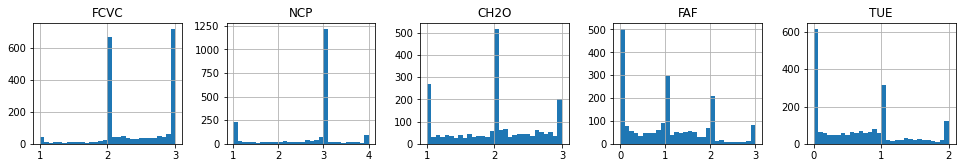

In [4]:
df[["FCVC","NCP","CH2O","FAF","TUE"]].hist(bins=30, figsize=(20, 8), layout=(3, 6))

We can therefore see from these various graphs that the majority of the data for these variables are integer values. The data that are not integers are the data that have been generated synthetically (77% of the data). 

It is therefore more appropriate to round the decimal values to the nearest integer. 

For example, for the variable CH2O. An individual knows his water consumption in a range, but does not know the exact quantity he consumes on a daily basis. 

Thus, if he consumes between 0 and 1L, we will have 1 in the dataframe, 2 if he consumes between 1 and 2L and finally 3 if he consumes more than 2L.

In [5]:
df["Gender"] = df["Gender"].apply(lambda x : 1 if x=="Female" else 0)
df["Age"] = df["Age"].apply(lambda x : int(float(int(x*100))/100))
df["Height"] = df["Height"].apply(lambda x : round(x,2))
df["Weight"] = df["Weight"].apply(lambda x : round(x,1))
df["Family_overweight"] = df["Family_overweight"].apply(lambda x : 1 if x=="yes" else 0)
df["FAVC"] = df["FAVC"].apply(lambda x : 1 if x=="yes" else 0)
df["FCVC"] = df["FCVC"].apply(lambda x : int(round(x,0)))
df["NCP"] = df["NCP"].apply(lambda x : int(round(x,0)))
df["CAEC"], unique_CAEC = pd.factorize(df["CAEC"], sort=True)
df["Smoke"] = df["Smoke"].apply(lambda x : 1 if x=="yes" else 0)
df["CH2O"] = df["CH2O"].apply(lambda x : round(x,0))
df["SCC"] = df["SCC"].apply(lambda x : 1 if x=="yes" else 0)
df["FAF"] = df["FAF"].apply(lambda x : int(round(x,0)))
df["TUE"] = df["TUE"].apply(lambda x : round(x,0))
df["CALC"], unique_CALC = pd.factorize(df["CALC"], sort=True)
# df["Transportation"], unique_Transportation = pd.factorize(df["Transportation"], sort=True)

transportation ={"Automobile": 1, "Bike": 2, "Motorbike": 3, "Public_Transportation": 4, "Walking": 5}

df["Transportation"] = df["Transportation"].map(transportation,na_action='ignore').apply(lambda x : int(x))

df

,Gender,Age,Height,Weight,Family_overweight,FAVC,FCVC,NCP,CAEC,Smoke,CH2O,SCC,FAF,TUE,CALC,Transportation,Obesity_level_category
0,1,21,1.62,64.0,1,0,2,3,2,0,2.0,0,0,1.0,3,4,Normal_Weight
1,1,21,1.52,56.0,1,0,3,3,2,1,3.0,1,3,0.0,2,4,Normal_Weight
2,0,23,1.80,77.0,1,0,2,3,2,0,2.0,0,2,1.0,1,4,Normal_Weight
3,0,27,1.80,87.0,0,0,3,3,2,0,2.0,0,2,0.0,1,5,Overweight_Level_I
4,0,22,1.78,89.8,0,0,2,1,2,0,2.0,0,0,0.0,2,4,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,1,20,1.71,131.4,1,1,3,3,2,0,2.0,0,2,1.0,2,4,Obesity_Type_III
2107,1,21,1.75,133.7,1,1,3,3,2,0,2.0,0,1,1.0,2,4,Obesity_Type_III
2108,1,22,1.75,133.7,1,1,3,3,2,0,2.0,0,1,1.0,2,4,Obesity_Type_III
2109,1,24,1.74,133.3,1,1,3,3,2,0,3.0,0,1,1.0,2,4,Obesity_Type_III


Transformation of the quantitative types of obesity level categories into numerical values, in order to study the correlation matrix, in the next part.

In [6]:
obesity_level ={"Insufficient_Weight": 0, "Normal_Weight": 1, "Overweight_Level_I": 2, "Overweight_Level_II": 3, "Obesity_Type_I": 4, "Obesity_Type_II": 5, "Obesity_Type_III": 6}

df["Obesity_level_category"] = df["Obesity_level_category"].map(obesity_level,na_action='ignore').apply(lambda x : int(x))

df

,Gender,Age,Height,Weight,Family_overweight,FAVC,FCVC,NCP,CAEC,Smoke,CH2O,SCC,FAF,TUE,CALC,Transportation,Obesity_level_category
0,1,21,1.62,64.0,1,0,2,3,2,0,2.0,0,0,1.0,3,4,1
1,1,21,1.52,56.0,1,0,3,3,2,1,3.0,1,3,0.0,2,4,1
2,0,23,1.80,77.0,1,0,2,3,2,0,2.0,0,2,1.0,1,4,1
3,0,27,1.80,87.0,0,0,3,3,2,0,2.0,0,2,0.0,1,5,2
4,0,22,1.78,89.8,0,0,2,1,2,0,2.0,0,0,0.0,2,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,1,20,1.71,131.4,1,1,3,3,2,0,2.0,0,2,1.0,2,4,6
2107,1,21,1.75,133.7,1,1,3,3,2,0,2.0,0,1,1.0,2,4,6
2108,1,22,1.75,133.7,1,1,3,3,2,0,2.0,0,1,1.0,2,4,6
2109,1,24,1.74,133.3,1,1,3,3,2,0,3.0,0,1,1.0,2,4,6


#Visualization of the data and correlation

##Correlation matrix

The correlation matrix of the different variables in the dataset is plotted below in order to visualise which variables are more or less correlated with the obesity level category.

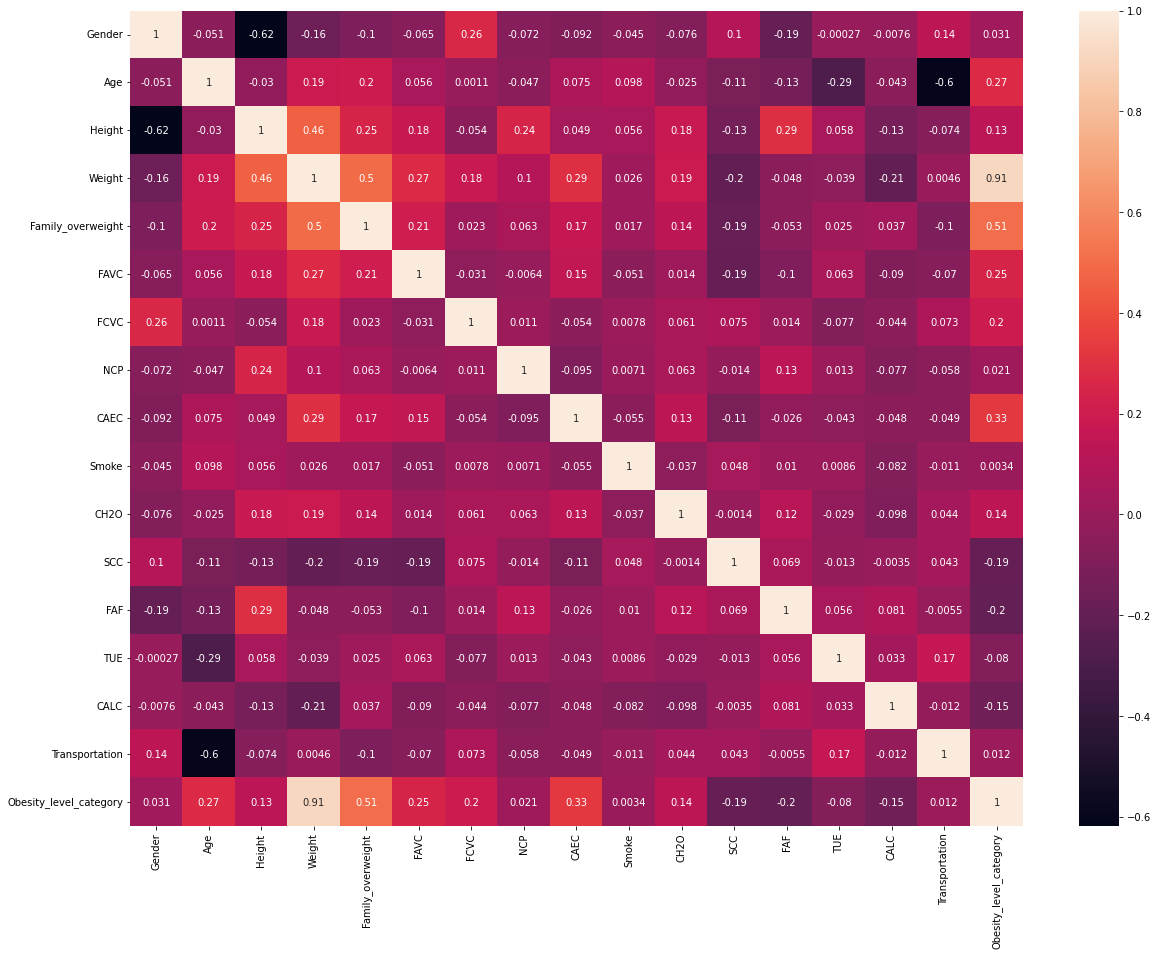

In [7]:
corr_df = df.corr()

plt.figure(figsize=(20, 15))
sns.heatmap(corr_df, annot=True)
plt.show()

We notice that the variable Weight is highly correlated with the level of obesity, which is logical since weight is very determinant in determining the level of obesity with the BMI.

We also notice that some variables have very little influence on the level of obesity, which is the case for example with the variables Smoke, Gender, NCP, or even the variable Transportation.

##Distribution of the data

Let us now study the distribution of the data in more details to determine whether certain columns are biased with respect to the representation of a normal population. 

Indeed, if we wish to set up a generalizable study and prediction model, we must work on a sample that is as representative as possible of the reality.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f37c1d467d0>,
      dtype=object)

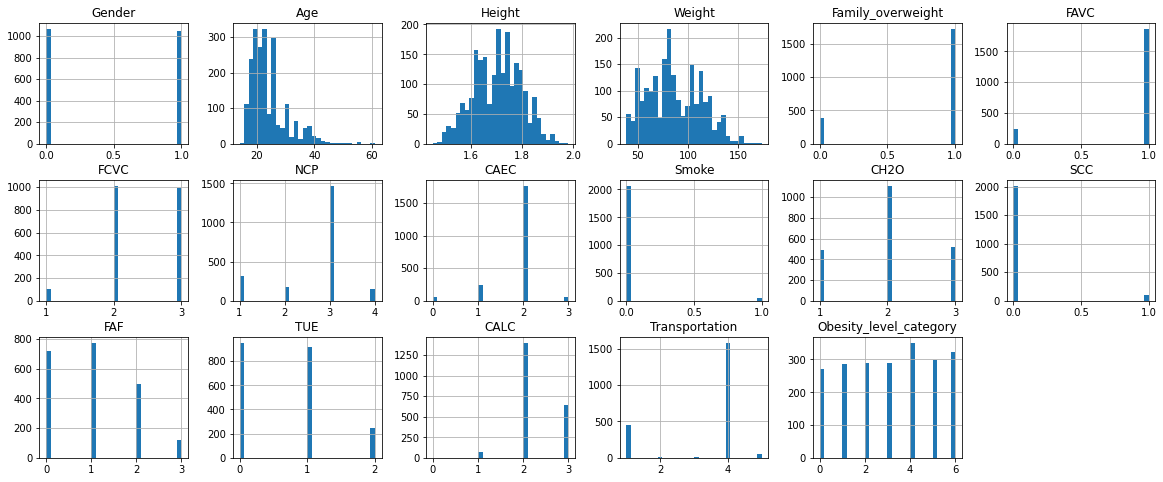

In [8]:
df[col_names].hist(bins=30, figsize=(20, 8), layout=(3, 6))

Although the age curve shows us that the sample is quite young, we see that there are as many men and women of different heights and weights. The sample is well representative of a real population.

Moreover, there is a homogeneous distribution of the different categories of obesity.

###Smoke variable

However, we can notice something quite surprising in the "Smoke" variable:

In [9]:
df.groupby("Smoke").count()["Gender"]

Smoke
0    2067
1      44
Name: Gender, dtype: int64

Text(0.5, 1.0, 'Smoker proportion')

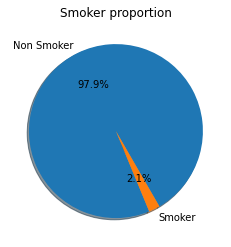

In [10]:
from collections import Counter
plt.pie(Counter(df['Smoke']).values(),labels=["Non Smoker", "Smoker"],autopct='%1.1f%%', startangle = -60, shadow=True)
plt.title('Smoker proportion')

We can see that 2% of our sample is a smoker, which is not representative of the number of people who smoke in South America. For example, 16% of the adult population smokes in Mexico, which is considerably more. 

Because there are not enough smokers in the sample, we doubt its true impact on obesity in this study, and we decide to remove the variable from the dataset.

In [11]:
df.drop(['Smoke'],axis = 1, inplace = True)

###Transportation variable

We can also observe above a rather uneven distribution in terms of means of transport

In [12]:
df_copie.groupby("MTRANS").count()["Gender"]

MTRANS
Automobile                457
Bike                        7
Motorbike                  11
Public_Transportation    1580
Walking                    56
Name: Gender, dtype: int64

In [13]:
Counter(df_copie['MTRANS'])

Counter({'Automobile': 457,
         'Bike': 7,
         'Motorbike': 11,
         'Public_Transportation': 1580,
         'Walking': 56})

Text(0.5, 1.0, 'Transport proportion')

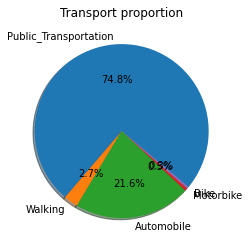

In [14]:
plt.pie(Counter(df_copie['MTRANS']).values(),labels=["Public_Transportation", "Walking", "Automobile", "Motorbike", "Bike"],autopct='%1.1f%%', startangle = -40, shadow=True)
plt.title('Transport proportion')

We can see that this variable tells us whether an individual uses a means of transport that requires physical effort (walking or cycling) or not (car, bus or motorbike). In order for this variable to have a greater impact on the prediction of obesity levels, by having a distinct boundary, we have chosen to transform the column by grouping together means of transport requiring physical effort and those not requiring any.

Thus, cars, motorbikes and public transport (categories 1, 3 and 4) will be categorised as 0 as they produce no physical effort, while walking and cycling (categories 2 and 5) will be categorised as 1.

In [15]:
df['Transportation']=np.where(df['Transportation']==1,0,df['Transportation']) #Automobile
df['Transportation']=np.where(df['Transportation']==3,0,df['Transportation']) #Motorbike
df['Transportation']=np.where(df['Transportation']==4,0,df['Transportation']) #Public transportation

df['Transportation']=np.where(df['Transportation']==2,1,df['Transportation']) #Bike
df['Transportation']=np.where(df['Transportation']==5,1,df['Transportation']) #Walking

###Pairwise relationships

We are going now, to plot different pairwise relationships in this dataset, in order to see if there are other interesting things to take into account.

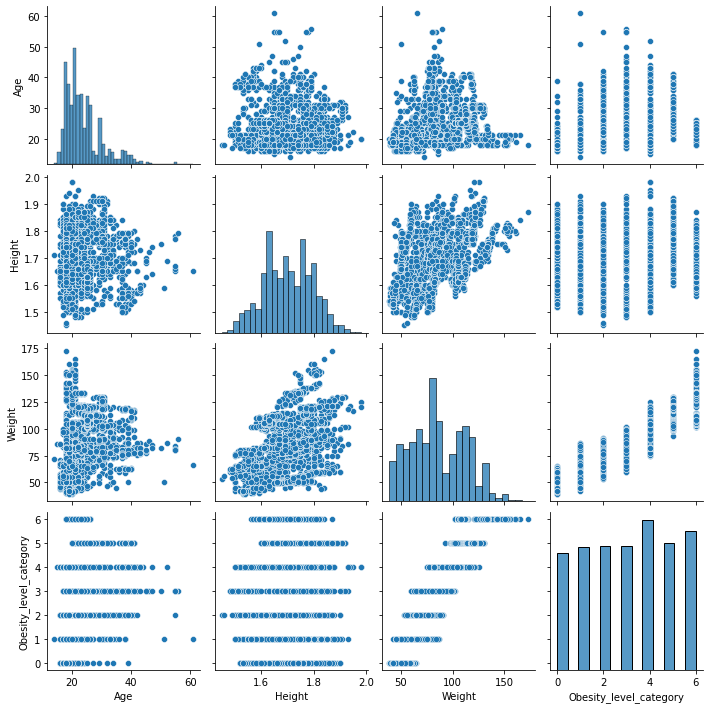

In [16]:
sns.pairplot(df[["Age","Height","Weight","Obesity_level_category"]])

It can be seen that as a person's weight increases, so does their level of obesity. 
Furthermore, height does not influence the level of obesity

This confirms that the IMC, to determine the level of obesity, is calculated from the weight of a person

# Processing models of Machine Learning

In [17]:
def Clean_dataframe(url):
  df = pd.read_csv(url)
  df.dropna(inplace=True)

  col_names = ["Gender", "Age", "Height", "Weight", "Family_overweight", "FAVC", "FCVC", "NCP", "CAEC", "Smoke", "CH2O", "SCC", "FAF", "TUE", "CALC", "Transportation", "Obesity_level_category"]
  df.columns = col_names

  df["Gender"] = df["Gender"].apply(lambda x : 1 if x=="Female" else 0)
  df["Age"] = df["Age"].apply(lambda x : int(float(int(x*100))/100))
  df["Height"] = df["Height"].apply(lambda x : round(x,2))
  df["Weight"] = df["Weight"].apply(lambda x : round(x,1))
  df["Family_overweight"] = df["Family_overweight"].apply(lambda x : 1 if x=="yes" else 0)
  df["FAVC"] = df["FAVC"].apply(lambda x : 1 if x=="yes" else 0)
  df["FCVC"] = df["FCVC"].apply(lambda x : int(round(x,0)))
  df["NCP"] = df["NCP"].apply(lambda x : int(round(x,0)))
  df["CAEC"], unique_CAEC = pd.factorize(df["CAEC"], sort=True)
  df["Smoke"] = df["Smoke"].apply(lambda x : 1 if x=="yes" else 0)
  df["CH2O"] = df["CH2O"].apply(lambda x : round(x,1))
  df["SCC"] = df["SCC"].apply(lambda x : 1 if x=="yes" else 0)
  df["FAF"] = df["FAF"].apply(lambda x : int(round(x,0)))
  df["TUE"] = df["TUE"].apply(lambda x : round(x,2))
  df["CALC"], unique_CALC = pd.factorize(df["CALC"], sort=True)

  transportation ={"Automobile": 1, "Bike": 2, "Motorbike": 3, "Public_Transportation": 4, "Walking": 5}

  df["Transportation"] = df["Transportation"].map(transportation,na_action='ignore').apply(lambda x : int(x))

  df['Transportation']=np.where(df['Transportation']==1,0,df['Transportation']) #Automobile
  df['Transportation']=np.where(df['Transportation']==3,0,df['Transportation']) #Motorbike
  df['Transportation']=np.where(df['Transportation']==4,0,df['Transportation']) #Public transportation

  df['Transportation']=np.where(df['Transportation']==2,1,df['Transportation']) #Bike
  df['Transportation']=np.where(df['Transportation']==5,1,df['Transportation']) #Walking

  #df.drop(['Weight'],axis = 1, inplace = True)
  df.drop(['Smoke'],axis = 1, inplace = True)

  return df

#Linear Discriminant Analysis

We will divide our prediction models into two parts: 

- On the one hand, the prediction of whether an individual belongs to a BMI range, with all classes ranging from underweight individuals to obese type III individuals. Our models for these types of prediction will be under the subheadings "All classes".

- On the other hand, we wanted to simplify the prediction to be done by reducing the number of classes to two (obese individuals and non-obese individuals). These models will be in the sub-headings "Binary classification".


##All classes

Data transformation and cleansing

In [18]:
df = Clean_dataframe(url)
df

,Gender,Age,Height,Weight,Family_overweight,FAVC,FCVC,NCP,CAEC,CH2O,SCC,FAF,TUE,CALC,Transportation,Obesity_level_category
0,1,21,1.62,64.0,1,0,2,3,2,2.0,0,0,1.00,3,0,Normal_Weight
1,1,21,1.52,56.0,1,0,3,3,2,3.0,1,3,0.00,2,0,Normal_Weight
2,0,23,1.80,77.0,1,0,2,3,2,2.0,0,2,1.00,1,0,Normal_Weight
3,0,27,1.80,87.0,0,0,3,3,2,2.0,0,2,0.00,1,1,Overweight_Level_I
4,0,22,1.78,89.8,0,0,2,1,2,2.0,0,0,0.00,2,0,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,1,20,1.71,131.4,1,1,3,3,2,1.7,0,2,0.91,2,0,Obesity_Type_III
2107,1,21,1.75,133.7,1,1,3,3,2,2.0,0,1,0.60,2,0,Obesity_Type_III
2108,1,22,1.75,133.7,1,1,3,3,2,2.1,0,1,0.65,2,0,Obesity_Type_III
2109,1,24,1.74,133.3,1,1,3,3,2,2.9,0,1,0.59,2,0,Obesity_Type_III


Separation of the dataset into training and test sets, with data centring and reduction

In [19]:
x=df.loc[:,df.columns!="Obesity_level_category"]
y=df.loc[:,df.columns=="Obesity_level_category"]

In [20]:
scaler=StandardScaler()
scaler.fit(x)
x_scaled=scaler.transform(x)

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.33)
x_train

array([[-0.98822657,  1.43130364,  0.41115632, ..., -1.08060789,
         1.4191716 , -0.17539019],
       [-0.98822657, -0.78839242,  1.16105226, ..., -0.57141966,
        -0.52115952, -0.17539019],
       [ 1.01191369, -0.6298427 ,  1.16105226, ...,  0.11844826,
        -0.52115952, -0.17539019],
       ...,
       [-0.98822657, -0.78839242,  1.26818026, ..., -0.30861284,
        -0.52115952, -0.17539019],
       [-0.98822657,  0.32145561,  0.6254123 , ...,  0.36482966,
        -0.52115952, -0.17539019],
       [ 1.01191369, -0.31274326, -0.33873962, ...,  0.56193477,
         1.4191716 , -0.17539019]])

We will now search for the best parameters for our model by applying a Gridsearch and cross-validation methods. 

In [22]:
parameters = {"solver": ["svd", "lsqr", "eigen"], "shrinkage": ["None", "auto"], "n_components" :["None", 5, 10, 15]}

In [23]:
lda = LinearDiscriminantAnalysis()

Implementation of cross-validation methods to assess the performance of the models:

In [24]:
def validation_curve_function(model, x, y, paramater, k):
  train_scores, val_scores=validation_curve(model,x , y, param_range=k, cv=5, param_name=paramater)
  plt.plot(k, val_scores.mean(axis=1))
  plt.plot(k, train_scores.mean(axis=1))

def cross_val_function(model, x, y):
  print(cross_val_score(model, x, y))

cross_val_function(lda, x_train, y_train)

[0.91166078 0.87985866 0.89399293 0.87279152 0.88297872]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

In [25]:
grid_search = GridSearchCV(estimator=lda,
                           param_grid=parameters,
                           cv=5,
                           verbose=4)

In [26]:
grid_search.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END n_components=None, shrinkage=None, solver=svd;, score=nan total time=   0.0s
[CV 2/5] END n_components=None, shrinkage=None, solver=svd;, score=nan total time=   0.0s
[CV 3/5] END n_components=None, shrinkage=None, solver=svd;, score=nan total time=   0.0s
[CV 4/5] END n_components=None, shrinkage=None, solver=svd;, score=nan total time=   0.0s
[CV 5/5] END n_components=None, shrinkage=None, solver=svd;, score=nan total time=   0.0s
[CV 1/5] END n_components=None, shrinkage=None, solver=lsqr;, score=nan total time=   0.0s
[CV 2/5] END n_components=None, shrinkage=None, solver=lsqr;, score=nan total time=   0.0s
[CV 3/5] END n_components=None, shrinkage=None, solver=lsqr;, score=nan total time=   0.0s
[CV 4/5] END n_components=None, shrinkage=None, solver=lsqr;, score=nan total time=   0.0s
[CV 5/5] END n_components=None, shrinkage=None, solver=lsqr;, score=nan total time=   0.0s
[CV 1/5] END n_components=None, s

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 3/5] END n_components=5, shrinkage=None, solver=lsqr;, score=nan total time=   0.0s
[CV 4/5] END n_components=5, shrinkage=None, solver=lsqr;, score=nan total time=   0.0s
[CV 5/5] END n_components=5, shrinkage=None, solver=lsqr;, score=nan total time=   0.0s
[CV 1/5] END n_components=5, shrinkage=None, solver=eigen;, score=nan total time=   0.0s
[CV 2/5] END n_components=5, shrinkage=None, solver=eigen;, score=nan total time=   0.0s
[CV 3/5] END n_components=5, shrinkage=None, solver=eigen;, score=nan total time=   0.0s
[CV 4/5] END n_components=5, shrinkage=None, solver=eigen;, score=nan total time=   0.0s
[CV 5/5] END n_components=5, shrinkage=None, solver=eigen;, score=nan total time=   0.0s
[CV 1/5] END n_components=5, shrinkage=auto, solver=svd;, score=nan total time=   0.0s
[CV 2/5] END n_components=5, shrinkage=auto, solver=svd;, score=nan total time=   0.0s
[CV 3/5] END n_components=5, shrinkage=auto, solver=svd;, score=nan total time=   0.0s
[CV 4/5] END n_components=5, s

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 2/5] END n_components=5, shrinkage=auto, solver=eigen;, score=0.809 total time=   0.0s
[CV 3/5] END n_components=5, shrinkage=auto, solver=eigen;, score=0.823 total time=   0.0s
[CV 4/5] END n_components=5, shrinkage=auto, solver=eigen;, score=0.816 total time=   0.0s
[CV 5/5] END n_components=5, shrinkage=auto, solver=eigen;, score=0.848 total time=   0.0s
[CV 1/5] END n_components=10, shrinkage=None, solver=svd;, score=nan total time=   0.0s
[CV 2/5] END n_components=10, shrinkage=None, solver=svd;, score=nan total time=   0.0s
[CV 3/5] END n_components=10, shrinkage=None, solver=svd;, score=nan total time=   0.0s
[CV 4/5] END n_components=10, shrinkage=None, solver=svd;, score=nan total time=   0.0s
[CV 5/5] END n_components=10, shrinkage=None, solver=svd;, score=nan total time=   0.0s
[CV 1/5] END n_components=10, shrinkage=None, solver=lsqr;, score=nan total time=   0.0s
[CV 2/5] END n_components=10, shrinkage=None, solver=lsqr;, score=nan total time=   0.0s
[CV 3/5] END n_com

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 3/5] END n_components=10, shrinkage=auto, solver=lsqr;, score=nan total time=   0.0s
[CV 4/5] END n_components=10, shrinkage=auto, solver=lsqr;, score=nan total time=   0.0s
[CV 5/5] END n_components=10, shrinkage=auto, solver=lsqr;, score=nan total time=   0.0s
[CV 1/5] END n_components=10, shrinkage=auto, solver=eigen;, score=nan total time=   0.0s
[CV 2/5] END n_components=10, shrinkage=auto, solver=eigen;, score=nan total time=   0.0s
[CV 3/5] END n_components=10, shrinkage=auto, solver=eigen;, score=nan total time=   0.0s
[CV 4/5] END n_components=10, shrinkage=auto, solver=eigen;, score=nan total time=   0.0s
[CV 5/5] END n_components=10, shrinkage=auto, solver=eigen;, score=nan total time=   0.0s
[CV 1/5] END n_components=15, shrinkage=None, solver=svd;, score=nan total time=   0.0s
[CV 2/5] END n_components=15, shrinkage=None, solver=svd;, score=nan total time=   0.0s
[CV 3/5] END n_components=15, shrinkage=None, solver=svd;, score=nan total time=   0.0s
[CV 4/5] END n_comp

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

GridSearchCV(cv=5, estimator=LinearDiscriminantAnalysis(),
             param_grid={'n_components': ['None', 5, 10, 15],
                         'shrinkage': ['None', 'auto'],
                         'solver': ['svd', 'lsqr', 'eigen']},
             verbose=4)

The best parameters for this model are therefore :

In [27]:
grid_search.best_params_

{'n_components': 5, 'shrinkage': 'auto', 'solver': 'lsqr'}

In [28]:
lda=LinearDiscriminantAnalysis(solver="lsqr", shrinkage="auto", n_components=5)

In [29]:
model_lda=lda.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [30]:
model_lda.coef_

array([[-3.71689217e-01, -1.15210218e+00,  3.79790028e+00,
        -1.68469734e+01, -1.28124691e+00,  1.30642657e-02,
         1.79852915e-01,  4.80023697e-01, -9.29534587e-01,
         1.03836336e-01, -1.04213021e-01,  8.87561717e-01,
         1.93312914e-01,  1.06796030e-01, -7.98900385e-02],
       [-8.85049571e-01, -6.11343049e-01,  2.04193138e+00,
        -1.07494095e+01, -7.64185966e-01, -2.97094280e-01,
        -3.65698698e-01,  6.08970118e-02, -1.25298600e+00,
        -1.10087572e-01,  1.19921941e-01,  8.00617851e-01,
         2.48347140e-02, -1.34135010e-01,  6.37706582e-01],
       [-7.20697213e-02,  2.84627007e-01, -9.02789270e-01,
         3.27177814e+00,  5.20608011e-01,  1.52344932e-01,
        -5.25213106e-01, -3.77737536e-01,  1.79737292e-01,
         1.58190516e-01, -2.40205722e-02, -1.14238330e-01,
         4.96714390e-02,  4.15164107e-01, -9.18237582e-02],
       [-7.86014319e-01,  1.01945000e+00, -2.00516199e+00,
         1.09645032e+01,  4.41149901e-01, -6.17818475

In [31]:
coef_fonctions_de_classement = pd.DataFrame(model_lda.coef_.transpose(), index=df.columns[:-1], columns=model_lda.classes_)
coef_fonctions_de_classement

,Insufficient_Weight,Normal_Weight,Obesity_Type_I,Obesity_Type_II,Obesity_Type_III,Overweight_Level_I,Overweight_Level_II
Gender,-0.371689,-0.885050,-0.072070,-0.786014,2.829222,-0.294856,-0.666994
Age,-1.152102,-0.611343,0.284627,1.019450,-0.119201,-0.208695,0.625657
Height,3.797900,2.041931,-0.902789,-2.005162,-3.411585,1.043088,0.430692
Weight,-16.846973,-10.749409,3.271778,10.964503,17.112715,-5.405936,-2.113071
Family_overweight,-1.281247,-0.764186,0.520608,0.441150,0.560796,-0.256026,0.442354
FAVC,0.013064,-0.297094,0.152345,-0.006178,0.336461,0.229587,-0.606584
FCVC,0.179853,-0.365699,-0.525213,-0.048618,1.195850,-0.361519,-0.280398
NCP,0.480024,0.060897,-0.377738,-0.229922,0.663637,-0.225938,-0.348992
CAEC,-0.929535,-1.252986,0.179737,0.405158,0.819812,0.399431,0.171936
CH2O,0.103836,-0.110088,0.158191,-0.644959,0.475566,0.121396,0.065689


In [32]:
print(model_lda.intercept_)

[-15.08468505  -8.0764828   -2.65337897  -8.14313855 -16.48306246
  -3.62390769  -2.74014674]


We now perform the prediction on our test set, to determine the real performance of our model.

In [33]:
pred = model_lda.predict(x_test)
pd.Series(pred).value_counts()

Obesity_Type_III       125
Obesity_Type_I         103
Obesity_Type_II        102
Overweight_Level_I     100
Insufficient_Weight     99
Overweight_Level_II     97
Normal_Weight           71
dtype: int64

In [34]:
pred = pd.DataFrame(pred)
pred.columns=y_test.columns

accuracy = np.where(pred.reset_index(drop=True)==y_test.reset_index(drop=True), 1, 0)
df_result_pred_test = pd.DataFrame(accuracy)
df_result_pred_test.columns = ["result"]

res_lda_all = 100*df_result_pred_test["result"].value_counts()[1]/len(df_result_pred_test["result"])
res_lda_all

83.0703012912482

Thus, we get 83.64% of accuracy with the lda method.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[0.84452297 0.80918728 0.82332155 0.81625442 0.84751773]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

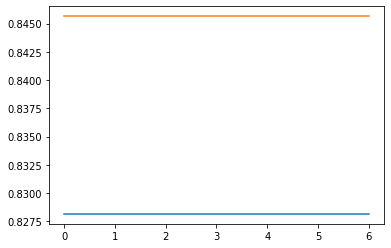

In [35]:
cross_val_function(lda, x_train, y_train)
validation_curve_function(lda, x_train, y_train, "n_components", np.arange(0,16,1))

It is difficult to be very precise with the 7 types of obesity as the dataset contains only 300 data for each type which seems relatively small to generalise the model.

Let's try to simplify the model by trying to predict only if an individual is obese or not.

##Binary classification using logistic regression

We will now try to simply predict whether an individual is obese or not.

We will re-transform the dataset, so that we have only two classes: 

* Obese people (types 1, 2 and 3)
* The others (Underweight, normal, overweight 1 and 2)



In [36]:
obesity_level ={"Insufficient_Weight": "Not obese", "Normal_Weight": "Not obese", "Overweight_Level_I": "Not obese", "Overweight_Level_II": "Not obese", "Obesity_Type_I": "Obese", "Obesity_Type_II": "Obese", "Obesity_Type_III": "Obese"}

df["Obesity_level_category"] = df["Obesity_level_category"].map(obesity_level,na_action='ignore').apply(lambda x : str(x))

df

,Gender,Age,Height,Weight,Family_overweight,FAVC,FCVC,NCP,CAEC,CH2O,SCC,FAF,TUE,CALC,Transportation,Obesity_level_category
0,1,21,1.62,64.0,1,0,2,3,2,2.0,0,0,1.00,3,0,Not obese
1,1,21,1.52,56.0,1,0,3,3,2,3.0,1,3,0.00,2,0,Not obese
2,0,23,1.80,77.0,1,0,2,3,2,2.0,0,2,1.00,1,0,Not obese
3,0,27,1.80,87.0,0,0,3,3,2,2.0,0,2,0.00,1,1,Not obese
4,0,22,1.78,89.8,0,0,2,1,2,2.0,0,0,0.00,2,0,Not obese
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,1,20,1.71,131.4,1,1,3,3,2,1.7,0,2,0.91,2,0,Obese
2107,1,21,1.75,133.7,1,1,3,3,2,2.0,0,1,0.60,2,0,Obese
2108,1,22,1.75,133.7,1,1,3,3,2,2.1,0,1,0.65,2,0,Obese
2109,1,24,1.74,133.3,1,1,3,3,2,2.9,0,1,0.59,2,0,Obese


In [37]:
x=df.loc[:,df.columns!="Obesity_level_category"]
y=df.loc[:,df.columns=="Obesity_level_category"]

scaler=StandardScaler()
scaler.fit(x)
x_scaled=scaler.transform(x)
y["Obesity_level_category"]

0       Not obese
1       Not obese
2       Not obese
3       Not obese
4       Not obese
          ...    
2106        Obese
2107        Obese
2108        Obese
2109        Obese
2110        Obese
Name: Obesity_level_category, Length: 2111, dtype: object

In [38]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.33)

In [39]:
lg = LogisticRegression()

parameters = {"penalty" : ['l1', 'l2', 'elasticnet', 'none'], "solver": ['newton-cg', 'lbfgs', 'liblinear'], "C": [10, 1.0, 0.1, 0.01]}

In [40]:
cross_val_function(lg, x_train, y_train)

[1.         0.99646643 0.99646643 0.99293286 0.9858156 ]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

In [41]:
grid_search = GridSearchCV(estimator=lg,
                           param_grid=parameters,
                           cv=5,
                           verbose=4)

In [42]:
grid_search.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END ..C=10, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END ..C=10, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END ..C=10, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END ..C=10, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END ..C=10, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END ......C=10, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END ......C=10, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END ......C=10, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END ......C=10, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END ......C=10, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5] END C=10, penalty=l1, solver=liblinear;, score=0.996 total time=   0.0s
[CV 2/5] END C=10, penalty=l1, solver=liblinear

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 3/5] END C=10, penalty=l2, solver=newton-cg;, score=0.996 total time=   0.0s
[CV 4/5] END C=10, penalty=l2, solver=newton-cg;, score=0.996 total time=   0.0s
[CV 5/5] END C=10, penalty=l2, solver=newton-cg;, score=0.993 total time=   0.0s
[CV 1/5] END ....C=10, penalty=l2, solver=lbfgs;, score=0.996 total time=   0.0s
[CV 2/5] END ....C=10, penalty=l2, solver=lbfgs;, score=0.996 total time=   0.0s
[CV 3/5] END ....C=10, penalty=l2, solver=lbfgs;, score=0.996 total time=   0.0s
[CV 4/5] END ....C=10, penalty=l2, solver=lbfgs;, score=0.996 total time=   0.0s
[CV 5/5] END ....C=10, penalty=l2, solver=lbfgs;, score=0.993 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 1/5] END C=10, penalty=l2, solver=liblinear;, score=0.996 total time=   0.0s
[CV 2/5] END C=10, penalty=l2, solver=liblinear;, score=0.996 total time=   0.0s
[CV 3/5] END C=10, penalty=l2, solver=liblinear;, score=0.996 total time=   0.0s
[CV 4/5] END C=10, penalty=l2, solver=liblinear;, score=0.996 total time=   0.0s
[CV 5/5] END C=10, penalty=l2, solver=liblinear;, score=0.993 total time=   0.0s
[CV 1/5] END C=10, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=10, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=10, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=10, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=10, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=10, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=10, penalty=elasticnet, solver=lbfgs;, score=nan total time=  

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, wa

[CV 3/5] END C=10, penalty=none, solver=newton-cg;, score=0.989 total time=   0.1s
[CV 4/5] END C=10, penalty=none, solver=newton-cg;, score=0.996 total time=   0.0s
[CV 5/5] END C=10, penalty=none, solver=newton-cg;, score=0.996 total time=   0.1s
[CV 1/5] END ..C=10, penalty=none, solver=lbfgs;, score=0.996 total time=   0.0s
[CV 2/5] END ..C=10, penalty=none, solver=lbfgs;, score=1.000 total time=   0.0s
[CV 3/5] END ..C=10, penalty=none, solver=lbfgs;, score=0.989 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/d

[CV 4/5] END ..C=10, penalty=none, solver=lbfgs;, score=1.000 total time=   0.0s
[CV 5/5] END ..C=10, penalty=none, solver=lbfgs;, score=0.996 total time=   0.0s
[CV 1/5] END C=10, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=10, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=10, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] END C=10, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5] END C=10, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5] END .C=1.0, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END .C=1.0, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END .C=1.0, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END .C=1.0, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END .C=1.0, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END .....C=1.0, pen

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, wa

[CV 3/5] END C=1.0, penalty=l2, solver=newton-cg;, score=0.996 total time=   0.0s
[CV 4/5] END C=1.0, penalty=l2, solver=newton-cg;, score=0.993 total time=   0.0s
[CV 5/5] END C=1.0, penalty=l2, solver=newton-cg;, score=0.986 total time=   0.0s
[CV 1/5] END ...C=1.0, penalty=l2, solver=lbfgs;, score=1.000 total time=   0.0s
[CV 2/5] END ...C=1.0, penalty=l2, solver=lbfgs;, score=0.996 total time=   0.0s
[CV 3/5] END ...C=1.0, penalty=l2, solver=lbfgs;, score=0.996 total time=   0.0s
[CV 4/5] END ...C=1.0, penalty=l2, solver=lbfgs;, score=0.993 total time=   0.0s
[CV 5/5] END ...C=1.0, penalty=l2, solver=lbfgs;, score=0.986 total time=   0.0s
[CV 1/5] END C=1.0, penalty=l2, solver=liblinear;, score=1.000 total time=   0.0s
[CV 2/5] END C=1.0, penalty=l2, solver=liblinear;, score=0.996 total time=   0.0s
[CV 3/5] END C=1.0, penalty=l2, solver=liblinear;, score=0.996 total time=   0.0s
[CV 4/5] END C=1.0, penalty=l2, solver=liblinear;, score=0.993 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 5/5] END C=1.0, penalty=l2, solver=liblinear;, score=0.986 total time=   0.0s
[CV 1/5] END C=1.0, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=1.0, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=1.0, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=1.0, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=1.0, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=1.0, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=1.0, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=1.0, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=1.0, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=1.0, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5] END C=1.0, penalty=elasticnet, solver=liblinear;,

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 4/5] END C=1.0, penalty=none, solver=newton-cg;, score=0.996 total time=   0.0s
[CV 5/5] END C=1.0, penalty=none, solver=newton-cg;, score=0.996 total time=   0.1s
[CV 1/5] END .C=1.0, penalty=none, solver=lbfgs;, score=0.996 total time=   0.0s
[CV 2/5] END .C=1.0, penalty=none, solver=lbfgs;, score=1.000 total time=   0.0s
[CV 3/5] END .C=1.0, penalty=none, solver=lbfgs;, score=0.989 total time=   0.0s
[CV 4/5] END .C=1.0, penalty=none, solver=lbfgs;, score=1.000 total time=   0.0s
[CV 5/5] END .C=1.0, penalty=none, solver=lbfgs;, score=0.996 total time=   0.0s
[CV 1/5] END C=1.0, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=1.0, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=1.0, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] END C=1.0, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5] END C=1.0, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5] END .C=0

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 1/5] END C=0.1, penalty=l1, solver=liblinear;, score=0.996 total time=   0.0s
[CV 2/5] END C=0.1, penalty=l1, solver=liblinear;, score=1.000 total time=   0.0s
[CV 3/5] END C=0.1, penalty=l1, solver=liblinear;, score=0.996 total time=   0.0s
[CV 4/5] END C=0.1, penalty=l1, solver=liblinear;, score=0.996 total time=   0.0s
[CV 5/5] END C=0.1, penalty=l1, solver=liblinear;, score=1.000 total time=   0.0s
[CV 1/5] END C=0.1, penalty=l2, solver=newton-cg;, score=0.982 total time=   0.0s
[CV 2/5] END C=0.1, penalty=l2, solver=newton-cg;, score=0.989 total time=   0.0s
[CV 3/5] END C=0.1, penalty=l2, solver=newton-cg;, score=0.989 total time=   0.0s
[CV 4/5] END C=0.1, penalty=l2, solver=newton-cg;, score=0.993 total time=   0.0s
[CV 5/5] END C=0.1, penalty=l2, solver=newton-cg;, score=0.975 total time=   0.0s
[CV 1/5] END ...C=0.1, penalty=l2, solver=lbfgs;, score=0.982 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 2/5] END ...C=0.1, penalty=l2, solver=lbfgs;, score=0.989 total time=   0.0s
[CV 3/5] END ...C=0.1, penalty=l2, solver=lbfgs;, score=0.989 total time=   0.0s
[CV 4/5] END ...C=0.1, penalty=l2, solver=lbfgs;, score=0.993 total time=   0.0s
[CV 5/5] END ...C=0.1, penalty=l2, solver=lbfgs;, score=0.975 total time=   0.0s
[CV 1/5] END C=0.1, penalty=l2, solver=liblinear;, score=0.982 total time=   0.0s
[CV 2/5] END C=0.1, penalty=l2, solver=liblinear;, score=0.986 total time=   0.0s
[CV 3/5] END C=0.1, penalty=l2, solver=liblinear;, score=0.989 total time=   0.0s
[CV 4/5] END C=0.1, penalty=l2, solver=liblinear;, score=0.993 total time=   0.0s
[CV 5/5] END C=0.1, penalty=l2, solver=liblinear;, score=0.975 total time=   0.0s
[CV 1/5] END C=0.1, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=0.1, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=0.1, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[C

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 1/5] END C=0.1, penalty=none, solver=newton-cg;, score=0.996 total time=   0.1s
[CV 2/5] END C=0.1, penalty=none, solver=newton-cg;, score=1.000 total time=   0.0s
[CV 3/5] END C=0.1, penalty=none, solver=newton-cg;, score=0.989 total time=   0.0s
[CV 4/5] END C=0.1, penalty=none, solver=newton-cg;, score=0.996 total time=   0.0s
[CV 5/5] END C=0.1, penalty=none, solver=newton-cg;, score=0.996 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/d

[CV 1/5] END .C=0.1, penalty=none, solver=lbfgs;, score=0.996 total time=   0.0s
[CV 2/5] END .C=0.1, penalty=none, solver=lbfgs;, score=1.000 total time=   0.0s
[CV 3/5] END .C=0.1, penalty=none, solver=lbfgs;, score=0.989 total time=   0.0s
[CV 4/5] END .C=0.1, penalty=none, solver=lbfgs;, score=1.000 total time=   0.0s
[CV 5/5] END .C=0.1, penalty=none, solver=lbfgs;, score=0.996 total time=   0.0s
[CV 1/5] END C=0.1, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=0.1, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=0.1, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] END C=0.1, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5] END C=0.1, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5] END C=0.01, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=0.01, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=0.01, pe

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/d

[CV 2/5] END C=0.01, penalty=l2, solver=newton-cg;, score=0.919 total time=   0.0s
[CV 3/5] END C=0.01, penalty=l2, solver=newton-cg;, score=0.961 total time=   0.0s
[CV 4/5] END C=0.01, penalty=l2, solver=newton-cg;, score=0.936 total time=   0.0s
[CV 5/5] END C=0.01, penalty=l2, solver=newton-cg;, score=0.918 total time=   0.0s
[CV 1/5] END ..C=0.01, penalty=l2, solver=lbfgs;, score=0.954 total time=   0.0s
[CV 2/5] END ..C=0.01, penalty=l2, solver=lbfgs;, score=0.919 total time=   0.0s
[CV 3/5] END ..C=0.01, penalty=l2, solver=lbfgs;, score=0.961 total time=   0.0s
[CV 4/5] END ..C=0.01, penalty=l2, solver=lbfgs;, score=0.936 total time=   0.0s
[CV 5/5] END ..C=0.01, penalty=l2, solver=lbfgs;, score=0.918 total time=   0.0s
[CV 1/5] END C=0.01, penalty=l2, solver=liblinear;, score=0.936 total time=   0.0s
[CV 2/5] END C=0.01, penalty=l2, solver=liblinear;, score=0.933 total time=   0.0s
[CV 3/5] END C=0.01, penalty=l2, solver=liblinear;, score=0.954 total time=   0.0s
[CV 4/5] END C

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin


[CV 5/5] END C=0.01, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5] END C=0.01, penalty=none, solver=newton-cg;, score=0.996 total time=   0.1s
[CV 2/5] END C=0.01, penalty=none, solver=newton-cg;, score=1.000 total time=   0.0s
[CV 3/5] END C=0.01, penalty=none, solver=newton-cg;, score=0.989 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/d

[CV 4/5] END C=0.01, penalty=none, solver=newton-cg;, score=0.996 total time=   0.1s
[CV 5/5] END C=0.01, penalty=none, solver=newton-cg;, score=0.996 total time=   0.1s
[CV 1/5] END C=0.01, penalty=none, solver=lbfgs;, score=0.996 total time=   0.0s
[CV 2/5] END C=0.01, penalty=none, solver=lbfgs;, score=1.000 total time=   0.0s
[CV 3/5] END C=0.01, penalty=none, solver=lbfgs;, score=0.989 total time=   0.0s
[CV 4/5] END C=0.01, penalty=none, solver=lbfgs;, score=1.000 total time=   0.0s
[CV 5/5] END C=0.01, penalty=none, solver=lbfgs;, score=0.996 total time=   0.0s
[CV 1/5] END C=0.01, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=0.01, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=0.01, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] END C=0.01, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5] END C=0.01, penalty=none, solver=liblinear;, score=nan total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/d

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [10, 1.0, 0.1, 0.01],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             verbose=4)

In [43]:
grid_search.best_params_

{'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}

In [44]:
lg = LogisticRegression(penalty='l2', C=0.01, solver='newton-cg')

In [45]:
model_lg = lg.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [46]:
pred = model_lg.predict(x_test)
pd.Series(pred).value_counts()

Not obese    357
Obese        340
dtype: int64

In [47]:
pred = pd.DataFrame(pred)
pred.columns=y_test.columns

accuracy = np.where(pred.reset_index(drop=True)==y_test.reset_index(drop=True), 1, 0)
df_result_pred_test = pd.DataFrame(accuracy)
df_result_pred_test.columns = ["result"]

res_lda_bin = 100*df_result_pred_test["result"].value_counts()[1]/len(df_result_pred_test["result"])
res_lda_bin

94.97847919655668

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

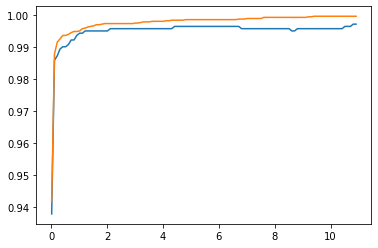

In [48]:
validation_curve_function(LogisticRegression(), x_train, y_train, "C", np.arange(0.01,11,0.1))

The logistic regression allows us to determine at 93,54% whether a person is obese or not.


The accuracy of the model increased by about 10% using only the 2 class model. 

This increase in accuracy is explained by the fact that when we had 7 different classes in the data set the boundaries between classes were not precise because the data overlapped and therefore the model was wrong on a large part of the predictions. 

However, by simplifying the model and grouping them into only 2 classes the algorithm is able to distinguish the boundaries between classes better and better.

#Knn

We will now try to use the K-nearest neighbors algorithm to see if we can increase the accuracy of predictions.

##All classes

In [49]:
df = Clean_dataframe(url)
df

,Gender,Age,Height,Weight,Family_overweight,FAVC,FCVC,NCP,CAEC,CH2O,SCC,FAF,TUE,CALC,Transportation,Obesity_level_category
0,1,21,1.62,64.0,1,0,2,3,2,2.0,0,0,1.00,3,0,Normal_Weight
1,1,21,1.52,56.0,1,0,3,3,2,3.0,1,3,0.00,2,0,Normal_Weight
2,0,23,1.80,77.0,1,0,2,3,2,2.0,0,2,1.00,1,0,Normal_Weight
3,0,27,1.80,87.0,0,0,3,3,2,2.0,0,2,0.00,1,1,Overweight_Level_I
4,0,22,1.78,89.8,0,0,2,1,2,2.0,0,0,0.00,2,0,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,1,20,1.71,131.4,1,1,3,3,2,1.7,0,2,0.91,2,0,Obesity_Type_III
2107,1,21,1.75,133.7,1,1,3,3,2,2.0,0,1,0.60,2,0,Obesity_Type_III
2108,1,22,1.75,133.7,1,1,3,3,2,2.1,0,1,0.65,2,0,Obesity_Type_III
2109,1,24,1.74,133.3,1,1,3,3,2,2.9,0,1,0.59,2,0,Obesity_Type_III


In [50]:
x=df.loc[:,df.columns!="Obesity_level_category"]
y=df.loc[:,df.columns=="Obesity_level_category"]

scaler=StandardScaler()
scaler.fit(x)
x_scaled=scaler.transform(x)

In [51]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.33)

In [52]:
knn = KNeighborsClassifier()
parameters = {"n_neighbors": range(3, 21, 2), "weights":['uniform', 'distance'], "metric":['euclidean', 'manhattan', 'minkowski']}

In [53]:
cross_val_function(knn, x_train, y_train)

[0.74204947 0.7844523  0.77031802 0.76325088 0.80141844]


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

In [54]:
grid_search = GridSearchCV(estimator=knn,
                           param_grid=parameters,
                           cv=5,
                           verbose=4)

In [55]:
grid_search.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV 1/5] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.756 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.781 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.756 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.749 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.791 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.795 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.802 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.788 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.774 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 5/5] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.805 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=5, weights=uniform;, score=0.742 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=5, weights=uniform;, score=0.784 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=5, weights=uniform;, score=0.770 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=5, weights=uniform;, score=0.763 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=5, weights=uniform;, score=0.801 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=5, weights=distance;, score=0.777 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=5, weights=distance;, score=0.806 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=5, weights=distance;, score=0.792 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 4/5] END metric=euclidean, n_neighbors=5, weights=distance;, score=0.784 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=5, weights=distance;, score=0.816 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=7, weights=uniform;, score=0.710 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=7, weights=uniform;, score=0.781 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=7, weights=uniform;, score=0.774 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=7, weights=uniform;, score=0.753 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=7, weights=uniform;, score=0.773 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=7, weights=distance;, score=0.753 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=7, weights=distance;, score=0.799 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 3/5] END metric=euclidean, n_neighbors=7, weights=distance;, score=0.781 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=7, weights=distance;, score=0.788 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=7, weights=distance;, score=0.798 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=9, weights=uniform;, score=0.710 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=9, weights=uniform;, score=0.753 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=9, weights=uniform;, score=0.756 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=9, weights=uniform;, score=0.749 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=9, weights=uniform;, score=0.787 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=9, weights=distance;, score=0.753 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 2/5] END metric=euclidean, n_neighbors=9, weights=distance;, score=0.792 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=9, weights=distance;, score=0.781 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=9, weights=distance;, score=0.788 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=9, weights=distance;, score=0.801 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=11, weights=uniform;, score=0.707 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=11, weights=uniform;, score=0.760 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=11, weights=uniform;, score=0.735 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=11, weights=uniform;, score=0.749 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=11, weights=uniform;, score=0.780 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=11, weights=distance;, score=0.753 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 2/5] END metric=euclidean, n_neighbors=11, weights=distance;, score=0.792 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=11, weights=distance;, score=0.767 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=11, weights=distance;, score=0.781 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=11, weights=distance;, score=0.801 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=13, weights=uniform;, score=0.710 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=13, weights=uniform;, score=0.749 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=13, weights=uniform;, score=0.731 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=13, weights=uniform;, score=0.746 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=13, weights=uniform;, score=0.770 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 1/5] END metric=euclidean, n_neighbors=13, weights=distance;, score=0.735 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=13, weights=distance;, score=0.792 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=13, weights=distance;, score=0.756 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=13, weights=distance;, score=0.774 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=13, weights=distance;, score=0.794 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=15, weights=uniform;, score=0.703 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=15, weights=uniform;, score=0.731 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=15, weights=uniform;, score=0.721 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=15, weights=uniform;, score=0.731 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 5/5] END metric=euclidean, n_neighbors=15, weights=uniform;, score=0.766 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=15, weights=distance;, score=0.742 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=15, weights=distance;, score=0.781 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=15, weights=distance;, score=0.746 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=15, weights=distance;, score=0.760 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=15, weights=distance;, score=0.794 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=17, weights=uniform;, score=0.689 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=17, weights=uniform;, score=0.731 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=17, weights=uniform;, score=0.703 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 4/5] END metric=euclidean, n_neighbors=17, weights=uniform;, score=0.728 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=17, weights=uniform;, score=0.770 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=17, weights=distance;, score=0.724 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=17, weights=distance;, score=0.777 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=17, weights=distance;, score=0.742 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=17, weights=distance;, score=0.774 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=17, weights=distance;, score=0.794 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=19, weights=uniform;, score=0.693 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=19, weights=uniform;, score=0.746 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 3/5] END metric=euclidean, n_neighbors=19, weights=uniform;, score=0.700 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=19, weights=uniform;, score=0.721 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=19, weights=uniform;, score=0.738 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=19, weights=distance;, score=0.742 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=19, weights=distance;, score=0.777 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=19, weights=distance;, score=0.753 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=19, weights=distance;, score=0.767 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=19, weights=distance;, score=0.787 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=3, weights=uniform;, score=0.827 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 2/5] END metric=manhattan, n_neighbors=3, weights=uniform;, score=0.827 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=3, weights=uniform;, score=0.806 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=3, weights=uniform;, score=0.806 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=3, weights=uniform;, score=0.844 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=3, weights=distance;, score=0.841 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=3, weights=distance;, score=0.852 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=3, weights=distance;, score=0.823 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=3, weights=distance;, score=0.837 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=3, weights=distance;, score=0.851 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=5, weights=uniform;, score=0.813 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 2/5] END metric=manhattan, n_neighbors=5, weights=uniform;, score=0.823 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=5, weights=uniform;, score=0.813 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=5, weights=uniform;, score=0.802 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=5, weights=uniform;, score=0.837 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=5, weights=distance;, score=0.834 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=5, weights=distance;, score=0.845 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=5, weights=distance;, score=0.834 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=5, weights=distance;, score=0.827 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=5, weights=distance;, score=0.851 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=7, weights=uniform;, score=0.799 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 2/5] END metric=manhattan, n_neighbors=7, weights=uniform;, score=0.827 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=7, weights=uniform;, score=0.813 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=7, weights=uniform;, score=0.792 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=7, weights=uniform;, score=0.823 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=7, weights=distance;, score=0.827 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=7, weights=distance;, score=0.869 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=7, weights=distance;, score=0.830 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=7, weights=distance;, score=0.809 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=7, weights=distance;, score=0.858 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 1/5] END metric=manhattan, n_neighbors=9, weights=uniform;, score=0.781 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=9, weights=uniform;, score=0.816 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=9, weights=uniform;, score=0.802 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=9, weights=uniform;, score=0.774 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=9, weights=uniform;, score=0.823 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=9, weights=distance;, score=0.823 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=9, weights=distance;, score=0.852 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=9, weights=distance;, score=0.820 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=9, weights=distance;, score=0.813 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 5/5] END metric=manhattan, n_neighbors=9, weights=distance;, score=0.862 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=11, weights=uniform;, score=0.781 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=11, weights=uniform;, score=0.802 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=11, weights=uniform;, score=0.802 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=11, weights=uniform;, score=0.781 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=11, weights=uniform;, score=0.819 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=11, weights=distance;, score=0.809 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=11, weights=distance;, score=0.845 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=11, weights=distance;, score=0.823 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 4/5] END metric=manhattan, n_neighbors=11, weights=distance;, score=0.802 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=11, weights=distance;, score=0.855 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=13, weights=uniform;, score=0.763 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=13, weights=uniform;, score=0.792 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=13, weights=uniform;, score=0.792 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=13, weights=uniform;, score=0.781 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=13, weights=uniform;, score=0.812 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=13, weights=distance;, score=0.792 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 2/5] END metric=manhattan, n_neighbors=13, weights=distance;, score=0.848 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=13, weights=distance;, score=0.809 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=13, weights=distance;, score=0.806 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=13, weights=distance;, score=0.844 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=15, weights=uniform;, score=0.721 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=15, weights=uniform;, score=0.802 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=15, weights=uniform;, score=0.770 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=15, weights=uniform;, score=0.756 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 5/5] END metric=manhattan, n_neighbors=15, weights=uniform;, score=0.809 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=15, weights=distance;, score=0.788 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=15, weights=distance;, score=0.837 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=15, weights=distance;, score=0.802 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=15, weights=distance;, score=0.806 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=15, weights=distance;, score=0.851 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=17, weights=uniform;, score=0.728 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=17, weights=uniform;, score=0.781 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=17, weights=uniform;, score=0.774 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 4/5] END metric=manhattan, n_neighbors=17, weights=uniform;, score=0.756 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=17, weights=uniform;, score=0.791 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=17, weights=distance;, score=0.770 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=17, weights=distance;, score=0.841 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=17, weights=distance;, score=0.809 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=17, weights=distance;, score=0.813 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=17, weights=distance;, score=0.848 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=19, weights=uniform;, score=0.721 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=19, weights=uniform;, score=0.774 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 3/5] END metric=manhattan, n_neighbors=19, weights=uniform;, score=0.749 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=19, weights=uniform;, score=0.739 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=19, weights=uniform;, score=0.780 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=19, weights=distance;, score=0.774 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=19, weights=distance;, score=0.820 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=19, weights=distance;, score=0.802 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=19, weights=distance;, score=0.799 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=19, weights=distance;, score=0.837 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=3, weights=uniform;, score=0.756 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 2/5] END metric=minkowski, n_neighbors=3, weights=uniform;, score=0.781 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=3, weights=uniform;, score=0.756 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=3, weights=uniform;, score=0.749 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=3, weights=uniform;, score=0.791 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=3, weights=distance;, score=0.795 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=3, weights=distance;, score=0.802 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=3, weights=distance;, score=0.788 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=3, weights=distance;, score=0.774 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=3, weights=distance;, score=0.805 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=5, weights=uniform;, score=0.742 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=5,

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam


[CV 3/5] END metric=minkowski, n_neighbors=5, weights=uniform;, score=0.770 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=5, weights=uniform;, score=0.763 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=5, weights=uniform;, score=0.801 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=5, weights=distance;, score=0.777 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=5, weights=distance;, score=0.806 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=5, weights=distance;, score=0.792 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=5, weights=distance;, score=0.784 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=5, weights=distance;, score=0.816 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=7, weights=uniform;, score=0.710 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 2/5] END metric=minkowski, n_neighbors=7, weights=uniform;, score=0.781 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=7, weights=uniform;, score=0.774 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=7, weights=uniform;, score=0.753 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=7, weights=uniform;, score=0.773 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=7, weights=distance;, score=0.753 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=7, weights=distance;, score=0.799 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=7, weights=distance;, score=0.781 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=7, weights=distance;, score=0.788 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=7, weights=distance;, score=0.798 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=9, weights=uniform;, score=0.710 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 2/5] END metric=minkowski, n_neighbors=9, weights=uniform;, score=0.753 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=9, weights=uniform;, score=0.756 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=9, weights=uniform;, score=0.749 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=9, weights=uniform;, score=0.787 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=9, weights=distance;, score=0.753 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=9, weights=distance;, score=0.792 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=9, weights=distance;, score=0.781 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=9, weights=distance;, score=0.788 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=9, weights=distance;, score=0.801 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=11, weights=uniform;, score=0.707 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 2/5] END metric=minkowski, n_neighbors=11, weights=uniform;, score=0.760 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=11, weights=uniform;, score=0.735 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=11, weights=uniform;, score=0.749 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=11, weights=uniform;, score=0.780 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=11, weights=distance;, score=0.753 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=11, weights=distance;, score=0.792 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=11, weights=distance;, score=0.767 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=11, weights=distance;, score=0.781 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=11, weights=distance;, score=0.801 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=13, weights=uniform;, score=0.710 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 2/5] END metric=minkowski, n_neighbors=13, weights=uniform;, score=0.749 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=13, weights=uniform;, score=0.731 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=13, weights=uniform;, score=0.746 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=13, weights=uniform;, score=0.770 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=13, weights=distance;, score=0.735 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=13, weights=distance;, score=0.792 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=13, weights=distance;, score=0.756 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=13, weights=distance;, score=0.774 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=13, weights=distance;, score=0.794 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 1/5] END metric=minkowski, n_neighbors=15, weights=uniform;, score=0.703 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=15, weights=uniform;, score=0.731 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=15, weights=uniform;, score=0.721 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=15, weights=uniform;, score=0.731 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=15, weights=uniform;, score=0.766 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=15, weights=distance;, score=0.742 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=15, weights=distance;, score=0.781 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=15, weights=distance;, score=0.746 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=15, weights=distance;, score=0.760 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 5/5] END metric=minkowski, n_neighbors=15, weights=distance;, score=0.794 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=17, weights=uniform;, score=0.689 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=17, weights=uniform;, score=0.731 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=17, weights=uniform;, score=0.703 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=17, weights=uniform;, score=0.728 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=17, weights=uniform;, score=0.770 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=17, weights=distance;, score=0.724 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=17, weights=distance;, score=0.777 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 3/5] END metric=minkowski, n_neighbors=17, weights=distance;, score=0.742 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=17, weights=distance;, score=0.774 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=17, weights=distance;, score=0.794 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=19, weights=uniform;, score=0.693 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=19, weights=uniform;, score=0.746 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=19, weights=uniform;, score=0.700 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=19, weights=uniform;, score=0.721 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=19, weights=uniform;, score=0.738 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 1/5] END metric=minkowski, n_neighbors=19, weights=distance;, score=0.742 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=19, weights=distance;, score=0.777 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=19, weights=distance;, score=0.753 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=19, weights=distance;, score=0.767 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=19, weights=distance;, score=0.787 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': range(3, 21, 2),
                         'weights': ['uniform', 'distance']},
             verbose=4)

In [56]:
grid_search.best_params_

{'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}

In [57]:
knn = KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')

In [58]:
model_knn_all = knn.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [59]:
pred = model_knn_all.predict(x_test)
pd.Series(pred).value_counts()

Obesity_Type_I         127
Obesity_Type_III       112
Overweight_Level_I     108
Insufficient_Weight     95
Obesity_Type_II         94
Overweight_Level_II     83
Normal_Weight           78
dtype: int64

In [60]:
pred = pd.DataFrame(pred)
pred.columns=y_test.columns

accuracy = np.where(pred.reset_index(drop=True)==y_test.reset_index(drop=True), 1, 0)
df_result_pred_test = pd.DataFrame(accuracy)
df_result_pred_test.columns = ["result"]

res_knn_all = 100*df_result_pred_test["result"].value_counts()[1]/len(df_result_pred_test["result"])
res_knn_all

85.65279770444764

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

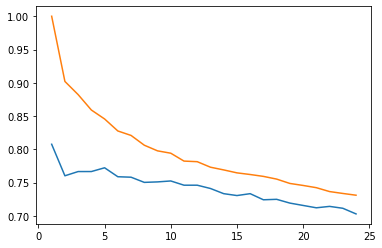

In [61]:
validation_curve_function(KNeighborsClassifier(), x_train, y_train, "n_neighbors", np.arange(1,25,1))

We can observe above on the validation curve, an overfitting phenomenon for a value of k=1.


We obtained 82% success in predicting the different types of obesity, which is significantly better than with the LDA model performed above.

Indeed, as the data overlap between the different classes, it is much more efficient and coherent to study the neighbours of an individual in space than to try to draw a border between the different classes.

##Classification binaire

In [62]:
obesity_level ={"Insufficient_Weight": "Not obese", "Normal_Weight": "Not obese", "Overweight_Level_I": "Not obese", "Overweight_Level_II": "Not obese", "Obesity_Type_I": "Obese", "Obesity_Type_II": "Obese", "Obesity_Type_III": "Obese"}

df["Obesity_level_category"] = df["Obesity_level_category"].map(obesity_level,na_action='ignore').apply(lambda x : str(x))

df

,Gender,Age,Height,Weight,Family_overweight,FAVC,FCVC,NCP,CAEC,CH2O,SCC,FAF,TUE,CALC,Transportation,Obesity_level_category
0,1,21,1.62,64.0,1,0,2,3,2,2.0,0,0,1.00,3,0,Not obese
1,1,21,1.52,56.0,1,0,3,3,2,3.0,1,3,0.00,2,0,Not obese
2,0,23,1.80,77.0,1,0,2,3,2,2.0,0,2,1.00,1,0,Not obese
3,0,27,1.80,87.0,0,0,3,3,2,2.0,0,2,0.00,1,1,Not obese
4,0,22,1.78,89.8,0,0,2,1,2,2.0,0,0,0.00,2,0,Not obese
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,1,20,1.71,131.4,1,1,3,3,2,1.7,0,2,0.91,2,0,Obese
2107,1,21,1.75,133.7,1,1,3,3,2,2.0,0,1,0.60,2,0,Obese
2108,1,22,1.75,133.7,1,1,3,3,2,2.1,0,1,0.65,2,0,Obese
2109,1,24,1.74,133.3,1,1,3,3,2,2.9,0,1,0.59,2,0,Obese


In [63]:
x=df.loc[:,df.columns!="Obesity_level_category"]
y=df.loc[:,df.columns=="Obesity_level_category"]

scaler=StandardScaler()
scaler.fit(x)
x_scaled=scaler.transform(x)

In [64]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.33)

In [65]:
knn = KNeighborsClassifier()
parameters = {"n_neighbors": range(3, 21, 2), "weights":['uniform', 'distance'], "metric":['euclidean', 'manhattan', 'minkowski']}

In [66]:
cross_val_function(knn, x_train, y_train)

[0.90106007 0.92932862 0.90812721 0.93286219 0.92553191]


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

In [67]:
grid_search = GridSearchCV(estimator=knn,
                           param_grid=parameters,
                           cv=5,
                           verbose=4)

In [68]:
grid_search.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV 1/5] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.915 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.936 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.919 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.943 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.922 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.922 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.940 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.929 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.947 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 5/5] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.926 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=5, weights=uniform;, score=0.901 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=5, weights=uniform;, score=0.929 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=5, weights=uniform;, score=0.908 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=5, weights=uniform;, score=0.933 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=5, weights=uniform;, score=0.926 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=5, weights=distance;, score=0.919 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=5, weights=distance;, score=0.940 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=5, weights=distance;, score=0.922 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=5, weights=distance;, score=0.940 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 5/5] END metric=euclidean, n_neighbors=5, weights=distance;, score=0.929 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=7, weights=uniform;, score=0.894 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=7, weights=uniform;, score=0.929 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=7, weights=uniform;, score=0.915 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=7, weights=uniform;, score=0.919 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=7, weights=uniform;, score=0.922 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=7, weights=distance;, score=0.922 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=7, weights=distance;, score=0.933 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=7, weights=distance;, score=0.929 total time=   0.0s

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam


[CV 4/5] END metric=euclidean, n_neighbors=7, weights=distance;, score=0.929 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=7, weights=distance;, score=0.943 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=9, weights=uniform;, score=0.883 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=9, weights=uniform;, score=0.922 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=9, weights=uniform;, score=0.919 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=9, weights=uniform;, score=0.915 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=9, weights=uniform;, score=0.908 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=9, weights=distance;, score=0.908 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 2/5] END metric=euclidean, n_neighbors=9, weights=distance;, score=0.936 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=9, weights=distance;, score=0.933 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=9, weights=distance;, score=0.940 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=9, weights=distance;, score=0.929 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=11, weights=uniform;, score=0.873 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=11, weights=uniform;, score=0.922 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=11, weights=uniform;, score=0.908 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=11, weights=uniform;, score=0.912 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 5/5] END metric=euclidean, n_neighbors=11, weights=uniform;, score=0.904 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=11, weights=distance;, score=0.890 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=11, weights=distance;, score=0.929 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=11, weights=distance;, score=0.926 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=11, weights=distance;, score=0.933 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=11, weights=distance;, score=0.926 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=13, weights=uniform;, score=0.876 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=13, weights=uniform;, score=0.908 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 3/5] END metric=euclidean, n_neighbors=13, weights=uniform;, score=0.919 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=13, weights=uniform;, score=0.894 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=13, weights=uniform;, score=0.904 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=13, weights=distance;, score=0.890 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=13, weights=distance;, score=0.936 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=13, weights=distance;, score=0.926 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=13, weights=distance;, score=0.915 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=13, weights=distance;, score=0.929 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 1/5] END metric=euclidean, n_neighbors=15, weights=uniform;, score=0.862 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=15, weights=uniform;, score=0.908 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=15, weights=uniform;, score=0.915 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=15, weights=uniform;, score=0.901 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=15, weights=uniform;, score=0.908 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=15, weights=distance;, score=0.890 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=15, weights=distance;, score=0.922 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 3/5] END metric=euclidean, n_neighbors=15, weights=distance;, score=0.929 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=15, weights=distance;, score=0.915 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=15, weights=distance;, score=0.929 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=17, weights=uniform;, score=0.866 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=17, weights=uniform;, score=0.908 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=17, weights=uniform;, score=0.926 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=17, weights=uniform;, score=0.898 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 5/5] END metric=euclidean, n_neighbors=17, weights=uniform;, score=0.901 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=17, weights=distance;, score=0.887 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=17, weights=distance;, score=0.926 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=17, weights=distance;, score=0.933 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=17, weights=distance;, score=0.919 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=17, weights=distance;, score=0.933 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=19, weights=uniform;, score=0.862 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=19, weights=uniform;, score=0.901 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 3/5] END metric=euclidean, n_neighbors=19, weights=uniform;, score=0.926 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=19, weights=uniform;, score=0.894 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=19, weights=uniform;, score=0.894 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=19, weights=distance;, score=0.890 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=19, weights=distance;, score=0.915 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=19, weights=distance;, score=0.933 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=19, weights=distance;, score=0.933 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=19, weights=distance;, score=0.922 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 1/5] END metric=manhattan, n_neighbors=3, weights=uniform;, score=0.933 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=3, weights=uniform;, score=0.961 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=3, weights=uniform;, score=0.929 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=3, weights=uniform;, score=0.951 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=3, weights=uniform;, score=0.950 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=3, weights=distance;, score=0.933 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=3, weights=distance;, score=0.961 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=3, weights=distance;, score=0.933 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 4/5] END metric=manhattan, n_neighbors=3, weights=distance;, score=0.951 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=3, weights=distance;, score=0.954 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=5, weights=uniform;, score=0.912 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=5, weights=uniform;, score=0.954 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=5, weights=uniform;, score=0.940 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=5, weights=uniform;, score=0.965 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=5, weights=uniform;, score=0.940 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=5, weights=distance;, score=0.933 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 2/5] END metric=manhattan, n_neighbors=5, weights=distance;, score=0.961 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=5, weights=distance;, score=0.940 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=5, weights=distance;, score=0.968 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=5, weights=distance;, score=0.950 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=7, weights=uniform;, score=0.919 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=7, weights=uniform;, score=0.936 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=7, weights=uniform;, score=0.929 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=7, weights=uniform;, score=0.951 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=7, weights=uniform;, score=0.947 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 1/5] END metric=manhattan, n_neighbors=7, weights=distance;, score=0.943 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=7, weights=distance;, score=0.954 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=7, weights=distance;, score=0.936 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=7, weights=distance;, score=0.961 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=7, weights=distance;, score=0.957 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=9, weights=uniform;, score=0.919 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=9, weights=uniform;, score=0.926 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=9, weights=uniform;, score=0.926 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=9, weights=uniform;, score=0.936 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 5/5] END metric=manhattan, n_neighbors=9, weights=uniform;, score=0.940 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=9, weights=distance;, score=0.940 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=9, weights=distance;, score=0.947 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=9, weights=distance;, score=0.933 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=9, weights=distance;, score=0.951 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=9, weights=distance;, score=0.961 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=11, weights=uniform;, score=0.912 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=11, weights=uniform;, score=0.919 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=11, weights=uniform;, score=0.926 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 4/5] END metric=manhattan, n_neighbors=11, weights=uniform;, score=0.926 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=11, weights=uniform;, score=0.926 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=11, weights=distance;, score=0.951 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=11, weights=distance;, score=0.940 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=11, weights=distance;, score=0.940 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=11, weights=distance;, score=0.943 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=11, weights=distance;, score=0.957 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=13, weights=uniform;, score=0.901 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=13, weights=uniform;, score=0.929 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 3/5] END metric=manhattan, n_neighbors=13, weights=uniform;, score=0.929 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=13, weights=uniform;, score=0.922 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=13, weights=uniform;, score=0.918 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=13, weights=distance;, score=0.936 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=13, weights=distance;, score=0.951 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=13, weights=distance;, score=0.940 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=13, weights=distance;, score=0.940 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=13, weights=distance;, score=0.954 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=15, weights=uniform;, score=0.898 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 2/5] END metric=manhattan, n_neighbors=15, weights=uniform;, score=0.926 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=15, weights=uniform;, score=0.936 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=15, weights=uniform;, score=0.926 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=15, weights=uniform;, score=0.926 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=15, weights=distance;, score=0.926 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=15, weights=distance;, score=0.951 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=15, weights=distance;, score=0.940 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=15, weights=distance;, score=0.943 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=15, weights=distance;, score=0.957 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 1/5] END metric=manhattan, n_neighbors=17, weights=uniform;, score=0.905 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=17, weights=uniform;, score=0.933 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=17, weights=uniform;, score=0.929 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=17, weights=uniform;, score=0.926 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=17, weights=uniform;, score=0.922 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=17, weights=distance;, score=0.933 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=17, weights=distance;, score=0.943 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=17, weights=distance;, score=0.936 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=17, weights=distance;, score=0.943 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 5/5] END metric=manhattan, n_neighbors=17, weights=distance;, score=0.957 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=19, weights=uniform;, score=0.905 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=19, weights=uniform;, score=0.926 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=19, weights=uniform;, score=0.929 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=19, weights=uniform;, score=0.919 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=19, weights=uniform;, score=0.915 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=19, weights=distance;, score=0.933 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=19, weights=distance;, score=0.943 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 3/5] END metric=manhattan, n_neighbors=19, weights=distance;, score=0.940 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=19, weights=distance;, score=0.936 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=19, weights=distance;, score=0.961 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=3, weights=uniform;, score=0.915 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=3, weights=uniform;, score=0.936 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=3, weights=uniform;, score=0.919 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=3, weights=uniform;, score=0.943 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=3, weights=uniform;, score=0.922 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=3, weights=distance;, score=0.922 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=3, weights=distance;, score=0.940 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 3/5] END metric=minkowski, n_neighbors=3, weights=distance;, score=0.929 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=3, weights=distance;, score=0.947 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=3, weights=distance;, score=0.926 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=5, weights=uniform;, score=0.901 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=5, weights=uniform;, score=0.929 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=5, weights=uniform;, score=0.908 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=5, weights=uniform;, score=0.933 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=5, weights=uniform;, score=0.926 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=5, weights=distance;, score=0.919 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=5, weights=distance;, score=0.940 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 3/5] END metric=minkowski, n_neighbors=5, weights=distance;, score=0.922 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=5, weights=distance;, score=0.940 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=5, weights=distance;, score=0.929 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=7, weights=uniform;, score=0.894 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=7, weights=uniform;, score=0.929 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=7, weights=uniform;, score=0.915 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=7, weights=uniform;, score=0.919 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=7, weights=uniform;, score=0.922 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=7, weights=distance;, score=0.922 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=7, weights=distance;, score=0.933 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 3/5] END metric=minkowski, n_neighbors=7, weights=distance;, score=0.929 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=7, weights=distance;, score=0.929 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=7, weights=distance;, score=0.943 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=9, weights=uniform;, score=0.883 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=9, weights=uniform;, score=0.922 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=9, weights=uniform;, score=0.919 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=9, weights=uniform;, score=0.915 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=9, weights=uniform;, score=0.908 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=9, weights=distance;, score=0.908 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=9, weights=distance;, score=0.936 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 3/5] END metric=minkowski, n_neighbors=9, weights=distance;, score=0.933 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=9, weights=distance;, score=0.940 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=9, weights=distance;, score=0.929 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=11, weights=uniform;, score=0.873 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=11, weights=uniform;, score=0.922 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=11, weights=uniform;, score=0.908 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=11, weights=uniform;, score=0.912 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=11, weights=uniform;, score=0.904 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=11, weights=distance;, score=0.890 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=11, weights=distance;, score=0.929 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 3/5] END metric=minkowski, n_neighbors=11, weights=distance;, score=0.926 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=11, weights=distance;, score=0.933 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=11, weights=distance;, score=0.926 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=13, weights=uniform;, score=0.876 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=13, weights=uniform;, score=0.908 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=13, weights=uniform;, score=0.919 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=13, weights=uniform;, score=0.894 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=13, weights=uniform;, score=0.904 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=13, weights=distance;, score=0.890 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 2/5] END metric=minkowski, n_neighbors=13, weights=distance;, score=0.936 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=13, weights=distance;, score=0.926 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=13, weights=distance;, score=0.915 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=13, weights=distance;, score=0.929 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=15, weights=uniform;, score=0.862 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=15, weights=uniform;, score=0.908 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=15, weights=uniform;, score=0.915 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=15, weights=uniform;, score=0.901 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=15, weights=uniform;, score=0.908 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 1/5] END metric=minkowski, n_neighbors=15, weights=distance;, score=0.890 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=15, weights=distance;, score=0.922 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=15, weights=distance;, score=0.929 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=15, weights=distance;, score=0.915 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=15, weights=distance;, score=0.929 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=17, weights=uniform;, score=0.866 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=17, weights=uniform;, score=0.908 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=17, weights=uniform;, score=0.926 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=17, weights=uniform;, score=0.898 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 5/5] END metric=minkowski, n_neighbors=17, weights=uniform;, score=0.901 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=17, weights=distance;, score=0.887 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=17, weights=distance;, score=0.926 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=17, weights=distance;, score=0.933 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=17, weights=distance;, score=0.919 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=17, weights=distance;, score=0.933 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=19, weights=uniform;, score=0.862 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=19, weights=uniform;, score=0.901 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=19, weights=uniform;, score=0.926 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=19, weights=uniform;, score=0.894 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 5/5] END metric=minkowski, n_neighbors=19, weights=uniform;, score=0.894 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=19, weights=distance;, score=0.890 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=19, weights=distance;, score=0.915 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=19, weights=distance;, score=0.933 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=19, weights=distance;, score=0.933 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=19, weights=distance;, score=0.922 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': range(3, 21, 2),
                         'weights': ['uniform', 'distance']},
             verbose=4)

In [69]:
grid_search.best_params_

{'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}

In [70]:
knn = KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')

In [71]:
model_knn_bin = knn.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [72]:
pred = model_knn_bin.predict(x_test)
pd.Series(pred).value_counts()

Not obese    379
Obese        318
dtype: int64

In [73]:
pred = pd.DataFrame(pred)
pred.columns=y_test.columns

accuracy = np.where(pred.reset_index(drop=True)==y_test.reset_index(drop=True), 1, 0)
df_result_pred_test = pd.DataFrame(accuracy)
df_result_pred_test.columns = ["result"]

res_knn_bin = 100*df_result_pred_test["result"].value_counts()[1]/len(df_result_pred_test["result"])
res_knn_bin

96.4131994261119

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

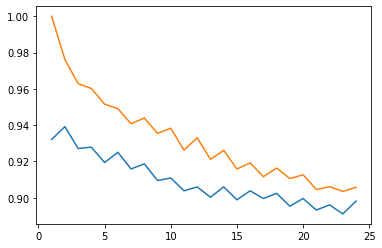

In [74]:
validation_curve_function(KNeighborsClassifier(), x_train, y_train, "n_neighbors", np.arange(1,25,1))

With the Knn we obtain 94,4% of success on the classification which confirms the conclusion made during the first test of the Knn on all the classes of the dataset.

#SVM

##All classes

In [75]:
df = Clean_dataframe(url)
df

,Gender,Age,Height,Weight,Family_overweight,FAVC,FCVC,NCP,CAEC,CH2O,SCC,FAF,TUE,CALC,Transportation,Obesity_level_category
0,1,21,1.62,64.0,1,0,2,3,2,2.0,0,0,1.00,3,0,Normal_Weight
1,1,21,1.52,56.0,1,0,3,3,2,3.0,1,3,0.00,2,0,Normal_Weight
2,0,23,1.80,77.0,1,0,2,3,2,2.0,0,2,1.00,1,0,Normal_Weight
3,0,27,1.80,87.0,0,0,3,3,2,2.0,0,2,0.00,1,1,Overweight_Level_I
4,0,22,1.78,89.8,0,0,2,1,2,2.0,0,0,0.00,2,0,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,1,20,1.71,131.4,1,1,3,3,2,1.7,0,2,0.91,2,0,Obesity_Type_III
2107,1,21,1.75,133.7,1,1,3,3,2,2.0,0,1,0.60,2,0,Obesity_Type_III
2108,1,22,1.75,133.7,1,1,3,3,2,2.1,0,1,0.65,2,0,Obesity_Type_III
2109,1,24,1.74,133.3,1,1,3,3,2,2.9,0,1,0.59,2,0,Obesity_Type_III


In [76]:
x=df.loc[:,df.columns!="Obesity_level_category"]
y=df.loc[:,df.columns=="Obesity_level_category"]

scaler=StandardScaler()
scaler.fit(x)
x_scaled=scaler.transform(x)

In [77]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.33)

In [78]:
svm_svc = SVC()
parameters = {"kernel": ['poly', 'rbf', 'sigmoid'], "C": [50, 25, 10, 5, 1.0, 0.1, 0.01], "gamma": ['scale', 'auto']}

In [79]:
cross_val_function(svm_svc, x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0.8409894  0.84805654 0.86219081 0.86219081 0.84751773]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [80]:
grid_search = GridSearchCV(estimator=svm_svc,
                           param_grid=parameters,
                           cv=5,
                           verbose=4)

In [81]:
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 42 candidates, totalling 210 fits
[CV 1/5] END ....C=50, gamma=scale, kernel=poly;, score=0.862 total time=   0.1s
[CV 2/5] END ....C=50, gamma=scale, kernel=poly;, score=0.869 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END ....C=50, gamma=scale, kernel=poly;, score=0.845 total time=   0.1s
[CV 4/5] END ....C=50, gamma=scale, kernel=poly;, score=0.880 total time=   0.1s
[CV 5/5] END ....C=50, gamma=scale, kernel=poly;, score=0.830 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END .....C=50, gamma=scale, kernel=rbf;, score=0.901 total time=   0.1s
[CV 2/5] END .....C=50, gamma=scale, kernel=rbf;, score=0.922 total time=   0.1s
[CV 3/5] END .....C=50, gamma=scale, kernel=rbf;, score=0.890 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END .....C=50, gamma=scale, kernel=rbf;, score=0.915 total time=   0.1s
[CV 5/5] END .....C=50, gamma=scale, kernel=rbf;, score=0.890 total time=   0.1s
[CV 1/5] END .C=50, gamma=scale, kernel=sigmoid;, score=0.555 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END .C=50, gamma=scale, kernel=sigmoid;, score=0.572 total time=   0.1s
[CV 3/5] END .C=50, gamma=scale, kernel=sigmoid;, score=0.583 total time=   0.1s
[CV 4/5] END .C=50, gamma=scale, kernel=sigmoid;, score=0.590 total time=   0.1s
[CV 5/5] END .C=50, gamma=scale, kernel=sigmoid;, score=0.546 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 1/5] END .....C=50, gamma=auto, kernel=poly;, score=0.862 total time=   0.1s
[CV 2/5] END .....C=50, gamma=auto, kernel=poly;, score=0.869 total time=   0.1s
[CV 3/5] END .....C=50, gamma=auto, kernel=poly;, score=0.845 total time=   0.1s
[CV 4/5] END .....C=50, gamma=auto, kernel=poly;, score=0.880 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 5/5] END .....C=50, gamma=auto, kernel=poly;, score=0.830 total time=   0.1s
[CV 1/5] END ......C=50, gamma=auto, kernel=rbf;, score=0.901 total time=   0.1s
[CV 2/5] END ......C=50, gamma=auto, kernel=rbf;, score=0.922 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END ......C=50, gamma=auto, kernel=rbf;, score=0.890 total time=   0.1s
[CV 4/5] END ......C=50, gamma=auto, kernel=rbf;, score=0.915 total time=   0.1s
[CV 5/5] END ......C=50, gamma=auto, kernel=rbf;, score=0.890 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END ..C=50, gamma=auto, kernel=sigmoid;, score=0.555 total time=   0.1s
[CV 2/5] END ..C=50, gamma=auto, kernel=sigmoid;, score=0.587 total time=   0.1s
[CV 3/5] END ..C=50, gamma=auto, kernel=sigmoid;, score=0.580 total time=   0.1s
[CV 4/5] END ..C=50, gamma=auto, kernel=sigmoid;, score=0.572 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 5/5] END ..C=50, gamma=auto, kernel=sigmoid;, score=0.525 total time=   0.1s
[CV 1/5] END ....C=25, gamma=scale, kernel=poly;, score=0.862 total time=   0.1s
[CV 2/5] END ....C=25, gamma=scale, kernel=poly;, score=0.859 total time=   0.1s
[CV 3/5] END ....C=25, gamma=scale, kernel=poly;, score=0.852 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 4/5] END ....C=25, gamma=scale, kernel=poly;, score=0.869 total time=   0.1s
[CV 5/5] END ....C=25, gamma=scale, kernel=poly;, score=0.833 total time=   0.1s
[CV 1/5] END .....C=25, gamma=scale, kernel=rbf;, score=0.901 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END .....C=25, gamma=scale, kernel=rbf;, score=0.922 total time=   0.1s
[CV 3/5] END .....C=25, gamma=scale, kernel=rbf;, score=0.894 total time=   0.1s
[CV 4/5] END .....C=25, gamma=scale, kernel=rbf;, score=0.908 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END .....C=25, gamma=scale, kernel=rbf;, score=0.887 total time=   0.1s
[CV 1/5] END .C=25, gamma=scale, kernel=sigmoid;, score=0.601 total time=   0.1s
[CV 2/5] END .C=25, gamma=scale, kernel=sigmoid;, score=0.580 total time=   0.1s
[CV 3/5] END .C=25, gamma=scale, kernel=sigmoid;, score=0.583 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 4/5] END .C=25, gamma=scale, kernel=sigmoid;, score=0.594 total time=   0.1s
[CV 5/5] END .C=25, gamma=scale, kernel=sigmoid;, score=0.539 total time=   0.1s
[CV 1/5] END .....C=25, gamma=auto, kernel=poly;, score=0.862 total time=   0.1s
[CV 2/5] END .....C=25, gamma=auto, kernel=poly;, score=0.859 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 3/5] END .....C=25, gamma=auto, kernel=poly;, score=0.852 total time=   0.1s
[CV 4/5] END .....C=25, gamma=auto, kernel=poly;, score=0.866 total time=   0.1s
[CV 5/5] END .....C=25, gamma=auto, kernel=poly;, score=0.833 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END ......C=25, gamma=auto, kernel=rbf;, score=0.901 total time=   0.1s
[CV 2/5] END ......C=25, gamma=auto, kernel=rbf;, score=0.922 total time=   0.1s
[CV 3/5] END ......C=25, gamma=auto, kernel=rbf;, score=0.894 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END ......C=25, gamma=auto, kernel=rbf;, score=0.912 total time=   0.1s
[CV 5/5] END ......C=25, gamma=auto, kernel=rbf;, score=0.887 total time=   0.1s
[CV 1/5] END ..C=25, gamma=auto, kernel=sigmoid;, score=0.601 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END ..C=25, gamma=auto, kernel=sigmoid;, score=0.580 total time=   0.1s
[CV 3/5] END ..C=25, gamma=auto, kernel=sigmoid;, score=0.558 total time=   0.1s
[CV 4/5] END ..C=25, gamma=auto, kernel=sigmoid;, score=0.587 total time=   0.1s
[CV 5/5] END ..C=25, gamma=auto, kernel=sigmoid;, score=0.535 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 1/5] END ....C=10, gamma=scale, kernel=poly;, score=0.841 total time=   0.1s
[CV 2/5] END ....C=10, gamma=scale, kernel=poly;, score=0.862 total time=   0.1s
[CV 3/5] END ....C=10, gamma=scale, kernel=poly;, score=0.830 total time=   0.1s
[CV 4/5] END ....C=10, gamma=scale, kernel=poly;, score=0.869 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 5/5] END ....C=10, gamma=scale, kernel=poly;, score=0.826 total time=   0.1s
[CV 1/5] END .....C=10, gamma=scale, kernel=rbf;, score=0.908 total time=   0.1s
[CV 2/5] END .....C=10, gamma=scale, kernel=rbf;, score=0.912 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END .....C=10, gamma=scale, kernel=rbf;, score=0.887 total time=   0.1s
[CV 4/5] END .....C=10, gamma=scale, kernel=rbf;, score=0.912 total time=   0.1s
[CV 5/5] END .....C=10, gamma=scale, kernel=rbf;, score=0.890 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END .C=10, gamma=scale, kernel=sigmoid;, score=0.597 total time=   0.1s
[CV 2/5] END .C=10, gamma=scale, kernel=sigmoid;, score=0.590 total time=   0.1s
[CV 3/5] END .C=10, gamma=scale, kernel=sigmoid;, score=0.576 total time=   0.1s
[CV 4/5] END .C=10, gamma=scale, kernel=sigmoid;, score=0.580 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 5/5] END .C=10, gamma=scale, kernel=sigmoid;, score=0.564 total time=   0.1s
[CV 1/5] END .....C=10, gamma=auto, kernel=poly;, score=0.841 total time=   0.1s
[CV 2/5] END .....C=10, gamma=auto, kernel=poly;, score=0.862 total time=   0.1s
[CV 3/5] END .....C=10, gamma=auto, kernel=poly;, score=0.830 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 4/5] END .....C=10, gamma=auto, kernel=poly;, score=0.869 total time=   0.1s
[CV 5/5] END .....C=10, gamma=auto, kernel=poly;, score=0.826 total time=   0.1s
[CV 1/5] END ......C=10, gamma=auto, kernel=rbf;, score=0.908 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END ......C=10, gamma=auto, kernel=rbf;, score=0.912 total time=   0.1s
[CV 3/5] END ......C=10, gamma=auto, kernel=rbf;, score=0.887 total time=   0.1s
[CV 4/5] END ......C=10, gamma=auto, kernel=rbf;, score=0.912 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END ......C=10, gamma=auto, kernel=rbf;, score=0.890 total time=   0.1s
[CV 1/5] END ..C=10, gamma=auto, kernel=sigmoid;, score=0.562 total time=   0.1s
[CV 2/5] END ..C=10, gamma=auto, kernel=sigmoid;, score=0.594 total time=   0.1s
[CV 3/5] END ..C=10, gamma=auto, kernel=sigmoid;, score=0.583 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 4/5] END ..C=10, gamma=auto, kernel=sigmoid;, score=0.587 total time=   0.1s
[CV 5/5] END ..C=10, gamma=auto, kernel=sigmoid;, score=0.574 total time=   0.1s
[CV 1/5] END .....C=5, gamma=scale, kernel=poly;, score=0.837 total time=   0.1s
[CV 2/5] END .....C=5, gamma=scale, kernel=poly;, score=0.852 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 3/5] END .....C=5, gamma=scale, kernel=poly;, score=0.834 total time=   0.1s
[CV 4/5] END .....C=5, gamma=scale, kernel=poly;, score=0.852 total time=   0.1s
[CV 5/5] END .....C=5, gamma=scale, kernel=poly;, score=0.837 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END ......C=5, gamma=scale, kernel=rbf;, score=0.898 total time=   0.1s
[CV 2/5] END ......C=5, gamma=scale, kernel=rbf;, score=0.908 total time=   0.1s
[CV 3/5] END ......C=5, gamma=scale, kernel=rbf;, score=0.876 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 4/5] END ......C=5, gamma=scale, kernel=rbf;, score=0.898 total time=   0.1s
[CV 5/5] END ......C=5, gamma=scale, kernel=rbf;, score=0.890 total time=   0.1s
[CV 1/5] END ..C=5, gamma=scale, kernel=sigmoid;, score=0.601 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END ..C=5, gamma=scale, kernel=sigmoid;, score=0.618 total time=   0.1s
[CV 3/5] END ..C=5, gamma=scale, kernel=sigmoid;, score=0.587 total time=   0.1s
[CV 4/5] END ..C=5, gamma=scale, kernel=sigmoid;, score=0.601 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END ..C=5, gamma=scale, kernel=sigmoid;, score=0.564 total time=   0.1s
[CV 1/5] END ......C=5, gamma=auto, kernel=poly;, score=0.837 total time=   0.1s
[CV 2/5] END ......C=5, gamma=auto, kernel=poly;, score=0.852 total time=   0.1s
[CV 3/5] END ......C=5, gamma=auto, kernel=poly;, score=0.834 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END ......C=5, gamma=auto, kernel=poly;, score=0.848 total time=   0.1s
[CV 5/5] END ......C=5, gamma=auto, kernel=poly;, score=0.837 total time=   0.1s
[CV 1/5] END .......C=5, gamma=auto, kernel=rbf;, score=0.898 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END .......C=5, gamma=auto, kernel=rbf;, score=0.908 total time=   0.1s
[CV 3/5] END .......C=5, gamma=auto, kernel=rbf;, score=0.876 total time=   0.1s
[CV 4/5] END .......C=5, gamma=auto, kernel=rbf;, score=0.898 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END .......C=5, gamma=auto, kernel=rbf;, score=0.890 total time=   0.1s
[CV 1/5] END ...C=5, gamma=auto, kernel=sigmoid;, score=0.594 total time=   0.1s
[CV 2/5] END ...C=5, gamma=auto, kernel=sigmoid;, score=0.618 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END ...C=5, gamma=auto, kernel=sigmoid;, score=0.590 total time=   0.1s
[CV 4/5] END ...C=5, gamma=auto, kernel=sigmoid;, score=0.580 total time=   0.1s
[CV 5/5] END ...C=5, gamma=auto, kernel=sigmoid;, score=0.571 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END ...C=1.0, gamma=scale, kernel=poly;, score=0.777 total time=   0.1s
[CV 2/5] END ...C=1.0, gamma=scale, kernel=poly;, score=0.799 total time=   0.1s
[CV 3/5] END ...C=1.0, gamma=scale, kernel=poly;, score=0.763 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END ...C=1.0, gamma=scale, kernel=poly;, score=0.770 total time=   0.1s
[CV 5/5] END ...C=1.0, gamma=scale, kernel=poly;, score=0.759 total time=   0.1s
[CV 1/5] END ....C=1.0, gamma=scale, kernel=rbf;, score=0.841 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END ....C=1.0, gamma=scale, kernel=rbf;, score=0.848 total time=   0.1s
[CV 3/5] END ....C=1.0, gamma=scale, kernel=rbf;, score=0.862 total time=   0.1s
[CV 4/5] END ....C=1.0, gamma=scale, kernel=rbf;, score=0.862 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END ....C=1.0, gamma=scale, kernel=rbf;, score=0.848 total time=   0.1s
[CV 1/5] END C=1.0, gamma=scale, kernel=sigmoid;, score=0.654 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END C=1.0, gamma=scale, kernel=sigmoid;, score=0.636 total time=   0.1s
[CV 3/5] END C=1.0, gamma=scale, kernel=sigmoid;, score=0.615 total time=   0.1s
[CV 4/5] END C=1.0, gamma=scale, kernel=sigmoid;, score=0.654 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END C=1.0, gamma=scale, kernel=sigmoid;, score=0.596 total time=   0.1s
[CV 1/5] END ....C=1.0, gamma=auto, kernel=poly;, score=0.777 total time=   0.1s
[CV 2/5] END ....C=1.0, gamma=auto, kernel=poly;, score=0.799 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END ....C=1.0, gamma=auto, kernel=poly;, score=0.767 total time=   0.1s
[CV 4/5] END ....C=1.0, gamma=auto, kernel=poly;, score=0.767 total time=   0.1s
[CV 5/5] END ....C=1.0, gamma=auto, kernel=poly;, score=0.762 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END .....C=1.0, gamma=auto, kernel=rbf;, score=0.841 total time=   0.1s
[CV 2/5] END .....C=1.0, gamma=auto, kernel=rbf;, score=0.848 total time=   0.1s
[CV 3/5] END .....C=1.0, gamma=auto, kernel=rbf;, score=0.862 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END .....C=1.0, gamma=auto, kernel=rbf;, score=0.862 total time=   0.1s
[CV 5/5] END .....C=1.0, gamma=auto, kernel=rbf;, score=0.848 total time=   0.1s
[CV 1/5] END .C=1.0, gamma=auto, kernel=sigmoid;, score=0.657 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END .C=1.0, gamma=auto, kernel=sigmoid;, score=0.636 total time=   0.1s
[CV 3/5] END .C=1.0, gamma=auto, kernel=sigmoid;, score=0.618 total time=   0.1s
[CV 4/5] END .C=1.0, gamma=auto, kernel=sigmoid;, score=0.643 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END .C=1.0, gamma=auto, kernel=sigmoid;, score=0.585 total time=   0.1s
[CV 1/5] END ...C=0.1, gamma=scale, kernel=poly;, score=0.565 total time=   0.1s
[CV 2/5] END ...C=0.1, gamma=scale, kernel=poly;, score=0.604 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END ...C=0.1, gamma=scale, kernel=poly;, score=0.541 total time=   0.1s
[CV 4/5] END ...C=0.1, gamma=scale, kernel=poly;, score=0.615 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END ...C=0.1, gamma=scale, kernel=poly;, score=0.518 total time=   0.1s
[CV 1/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.668 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.675 total time=   0.1s
[CV 3/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.682 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.686 total time=   0.1s
[CV 5/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.649 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END C=0.1, gamma=scale, kernel=sigmoid;, score=0.580 total time=   0.2s
[CV 2/5] END C=0.1, gamma=scale, kernel=sigmoid;, score=0.611 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END C=0.1, gamma=scale, kernel=sigmoid;, score=0.608 total time=   0.1s
[CV 4/5] END C=0.1, gamma=scale, kernel=sigmoid;, score=0.594 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END C=0.1, gamma=scale, kernel=sigmoid;, score=0.564 total time=   0.2s
[CV 1/5] END ....C=0.1, gamma=auto, kernel=poly;, score=0.569 total time=   0.1s
[CV 2/5] END ....C=0.1, gamma=auto, kernel=poly;, score=0.604 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END ....C=0.1, gamma=auto, kernel=poly;, score=0.548 total time=   0.1s
[CV 4/5] END ....C=0.1, gamma=auto, kernel=poly;, score=0.590 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END ....C=0.1, gamma=auto, kernel=poly;, score=0.525 total time=   0.1s
[CV 1/5] END .....C=0.1, gamma=auto, kernel=rbf;, score=0.668 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END .....C=0.1, gamma=auto, kernel=rbf;, score=0.675 total time=   0.1s
[CV 3/5] END .....C=0.1, gamma=auto, kernel=rbf;, score=0.682 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END .....C=0.1, gamma=auto, kernel=rbf;, score=0.678 total time=   0.1s
[CV 5/5] END .....C=0.1, gamma=auto, kernel=rbf;, score=0.645 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END .C=0.1, gamma=auto, kernel=sigmoid;, score=0.587 total time=   0.2s
[CV 2/5] END .C=0.1, gamma=auto, kernel=sigmoid;, score=0.611 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END .C=0.1, gamma=auto, kernel=sigmoid;, score=0.608 total time=   0.2s
[CV 4/5] END .C=0.1, gamma=auto, kernel=sigmoid;, score=0.597 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END .C=0.1, gamma=auto, kernel=sigmoid;, score=0.571 total time=   0.2s
[CV 1/5] END ..C=0.01, gamma=scale, kernel=poly;, score=0.212 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END ..C=0.01, gamma=scale, kernel=poly;, score=0.198 total time=   0.1s
[CV 3/5] END ..C=0.01, gamma=scale, kernel=poly;, score=0.194 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END ..C=0.01, gamma=scale, kernel=poly;, score=0.208 total time=   0.1s
[CV 5/5] END ..C=0.01, gamma=scale, kernel=poly;, score=0.199 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END ...C=0.01, gamma=scale, kernel=rbf;, score=0.159 total time=   0.2s
[CV 2/5] END ...C=0.01, gamma=scale, kernel=rbf;, score=0.163 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END ...C=0.01, gamma=scale, kernel=rbf;, score=0.163 total time=   0.2s
[CV 4/5] END ...C=0.01, gamma=scale, kernel=rbf;, score=0.159 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END ...C=0.01, gamma=scale, kernel=rbf;, score=0.160 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END C=0.01, gamma=scale, kernel=sigmoid;, score=0.163 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END C=0.01, gamma=scale, kernel=sigmoid;, score=0.166 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END C=0.01, gamma=scale, kernel=sigmoid;, score=0.173 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END C=0.01, gamma=scale, kernel=sigmoid;, score=0.173 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END C=0.01, gamma=scale, kernel=sigmoid;, score=0.177 total time=   0.2s
[CV 1/5] END ...C=0.01, gamma=auto, kernel=poly;, score=0.212 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END ...C=0.01, gamma=auto, kernel=poly;, score=0.198 total time=   0.1s
[CV 3/5] END ...C=0.01, gamma=auto, kernel=poly;, score=0.194 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END ...C=0.01, gamma=auto, kernel=poly;, score=0.198 total time=   0.1s
[CV 5/5] END ...C=0.01, gamma=auto, kernel=poly;, score=0.199 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END ....C=0.01, gamma=auto, kernel=rbf;, score=0.159 total time=   0.2s
[CV 2/5] END ....C=0.01, gamma=auto, kernel=rbf;, score=0.163 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END ....C=0.01, gamma=auto, kernel=rbf;, score=0.163 total time=   0.2s
[CV 4/5] END ....C=0.01, gamma=auto, kernel=rbf;, score=0.159 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END ....C=0.01, gamma=auto, kernel=rbf;, score=0.160 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END C=0.01, gamma=auto, kernel=sigmoid;, score=0.166 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END C=0.01, gamma=auto, kernel=sigmoid;, score=0.166 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END C=0.01, gamma=auto, kernel=sigmoid;, score=0.173 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END C=0.01, gamma=auto, kernel=sigmoid;, score=0.177 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END C=0.01, gamma=auto, kernel=sigmoid;, score=0.177 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [50, 25, 10, 5, 1.0, 0.1, 0.01],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['poly', 'rbf', 'sigmoid']},
             verbose=4)

In [82]:
grid_search.best_params_

{'C': 50, 'gamma': 'scale', 'kernel': 'rbf'}

In [83]:
svm_svc = SVC(C=25, gamma='scale', kernel='rbf')
model_svm_all = svm_svc.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [84]:
pred = model_svm_all.predict(x_test)
pd.Series(pred).value_counts()

Obesity_Type_I         127
Obesity_Type_III       116
Normal_Weight           98
Overweight_Level_II     94
Obesity_Type_II         93
Overweight_Level_I      89
Insufficient_Weight     80
dtype: int64

In [85]:
pred = pd.DataFrame(pred)
pred.columns=y_test.columns

accuracy = np.where(pred.reset_index(drop=True)==y_test.reset_index(drop=True), 1, 0)
df_result_pred_test = pd.DataFrame(accuracy)
df_result_pred_test.columns = ["result"]

res_svm_all = 100*df_result_pred_test["result"].value_counts()[1]/len(df_result_pred_test["result"])
res_svm_all

92.25251076040172

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

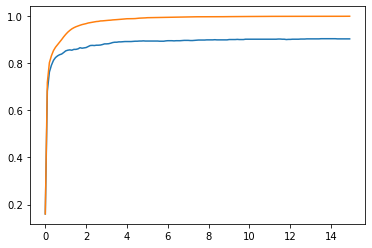

In [86]:
validation_curve_function(SVC(), x_train, y_train, "C", np.arange(0.01,15,0.1))

91,5% success rate.

##Binary classification

In [87]:
obesity_level ={"Insufficient_Weight": "Not obese", "Normal_Weight": "Not obese", "Overweight_Level_I": "Not obese", "Overweight_Level_II": "Not obese", "Obesity_Type_I": "Obese", "Obesity_Type_II": "Obese", "Obesity_Type_III": "Obese"}

df["Obesity_level_category"] = df["Obesity_level_category"].map(obesity_level,na_action='ignore').apply(lambda x : str(x))

df

,Gender,Age,Height,Weight,Family_overweight,FAVC,FCVC,NCP,CAEC,CH2O,SCC,FAF,TUE,CALC,Transportation,Obesity_level_category
0,1,21,1.62,64.0,1,0,2,3,2,2.0,0,0,1.00,3,0,Not obese
1,1,21,1.52,56.0,1,0,3,3,2,3.0,1,3,0.00,2,0,Not obese
2,0,23,1.80,77.0,1,0,2,3,2,2.0,0,2,1.00,1,0,Not obese
3,0,27,1.80,87.0,0,0,3,3,2,2.0,0,2,0.00,1,1,Not obese
4,0,22,1.78,89.8,0,0,2,1,2,2.0,0,0,0.00,2,0,Not obese
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,1,20,1.71,131.4,1,1,3,3,2,1.7,0,2,0.91,2,0,Obese
2107,1,21,1.75,133.7,1,1,3,3,2,2.0,0,1,0.60,2,0,Obese
2108,1,22,1.75,133.7,1,1,3,3,2,2.1,0,1,0.65,2,0,Obese
2109,1,24,1.74,133.3,1,1,3,3,2,2.9,0,1,0.59,2,0,Obese


In [88]:
x=df.loc[:,df.columns!="Obesity_level_category"]
y=df.loc[:,df.columns=="Obesity_level_category"]

scaler=StandardScaler()
scaler.fit(x)
x_scaled=scaler.transform(x)

In [89]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.33)

In [90]:
svm_svc = SVC()
parameters = {"kernel": ['poly', 'rbf', 'sigmoid'], "C": [50, 25, 10, 5, 1.0, 0.1, 0.01], "gamma": ['scale', 'auto']}

In [91]:
cross_val_function(svm_svc, x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[0.98939929 0.98939929 0.98939929 0.98586572 0.96808511]


In [92]:
grid_search = GridSearchCV(estimator=svm_svc,
                           param_grid=parameters,
                           cv=5,
                           verbose=4)

In [93]:
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 42 candidates, totalling 210 fits
[CV 1/5] END ....C=50, gamma=scale, kernel=poly;, score=0.965 total time=   0.0s
[CV 2/5] END ....C=50, gamma=scale, kernel=poly;, score=0.979 total time=   0.0s
[CV 3/5] END ....C=50, gamma=scale, kernel=poly;, score=0.979 total time=   0.0s
[CV 4/5] END ....C=50, gamma=scale, kernel=poly;, score=0.975 total time=   0.0s
[CV 5/5] END ....C=50, gamma=scale, kernel=poly;, score=0.972 total time=   0.0s
[CV 1/5] END .....C=50, gamma=scale, kernel=rbf;, score=0.993 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 2/5] END .....C=50, gamma=scale, kernel=rbf;, score=0.989 total time=   0.0s
[CV 3/5] END .....C=50, gamma=scale, kernel=rbf;, score=0.989 total time=   0.0s
[CV 4/5] END .....C=50, gamma=scale, kernel=rbf;, score=0.986 total time=   0.0s
[CV 5/5] END .....C=50, gamma=scale, kernel=rbf;, score=0.975 total time=   0.0s
[CV 1/5] END .C=50, gamma=scale, kernel=sigmoid;, score=0.901 total time=   0.0s
[CV 2/5] END .C=50, gamma=scale, kernel=sigmoid;, score=0.887 total time=   0.0s
[CV 3/5] END .C=50, gamma=scale, kernel=sigmoid;, score=0.901 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 4/5] END .C=50, gamma=scale, kernel=sigmoid;, score=0.908 total time=   0.0s
[CV 5/5] END .C=50, gamma=scale, kernel=sigmoid;, score=0.883 total time=   0.0s
[CV 1/5] END .....C=50, gamma=auto, kernel=poly;, score=0.968 total time=   0.0s
[CV 2/5] END .....C=50, gamma=auto, kernel=poly;, score=0.979 total time=   0.0s
[CV 3/5] END .....C=50, gamma=auto, kernel=poly;, score=0.975 total time=   0.0s
[CV 4/5] END .....C=50, gamma=auto, kernel=poly;, score=0.975 total time=   0.0s
[CV 5/5] END .....C=50, gamma=auto, kernel=poly;, score=0.972 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 1/5] END ......C=50, gamma=auto, kernel=rbf;, score=0.993 total time=   0.0s
[CV 2/5] END ......C=50, gamma=auto, kernel=rbf;, score=0.989 total time=   0.0s
[CV 3/5] END ......C=50, gamma=auto, kernel=rbf;, score=0.989 total time=   0.0s
[CV 4/5] END ......C=50, gamma=auto, kernel=rbf;, score=0.986 total time=   0.0s
[CV 5/5] END ......C=50, gamma=auto, kernel=rbf;, score=0.975 total time=   0.0s
[CV 1/5] END ..C=50, gamma=auto, kernel=sigmoid;, score=0.898 total time=   0.0s
[CV 2/5] END ..C=50, gamma=auto, kernel=sigmoid;, score=0.880 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 3/5] END ..C=50, gamma=auto, kernel=sigmoid;, score=0.898 total time=   0.0s
[CV 4/5] END ..C=50, gamma=auto, kernel=sigmoid;, score=0.908 total time=   0.0s
[CV 5/5] END ..C=50, gamma=auto, kernel=sigmoid;, score=0.879 total time=   0.0s
[CV 1/5] END ....C=25, gamma=scale, kernel=poly;, score=0.965 total time=   0.0s
[CV 2/5] END ....C=25, gamma=scale, kernel=poly;, score=0.979 total time=   0.0s
[CV 3/5] END ....C=25, gamma=scale, kernel=poly;, score=0.982 total time=   0.0s
[CV 4/5] END ....C=25, gamma=scale, kernel=poly;, score=0.982 total time=   0.0s
[CV 5/5] END ....C=25, gamma=scale, kernel=poly;, score=0.965 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 1/5] END .....C=25, gamma=scale, kernel=rbf;, score=0.989 total time=   0.0s
[CV 2/5] END .....C=25, gamma=scale, kernel=rbf;, score=0.989 total time=   0.0s
[CV 3/5] END .....C=25, gamma=scale, kernel=rbf;, score=0.989 total time=   0.0s
[CV 4/5] END .....C=25, gamma=scale, kernel=rbf;, score=0.986 total time=   0.0s
[CV 5/5] END .....C=25, gamma=scale, kernel=rbf;, score=0.975 total time=   0.0s
[CV 1/5] END .C=25, gamma=scale, kernel=sigmoid;, score=0.887 total time=   0.0s
[CV 2/5] END .C=25, gamma=scale, kernel=sigmoid;, score=0.887 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 3/5] END .C=25, gamma=scale, kernel=sigmoid;, score=0.890 total time=   0.0s
[CV 4/5] END .C=25, gamma=scale, kernel=sigmoid;, score=0.912 total time=   0.0s
[CV 5/5] END .C=25, gamma=scale, kernel=sigmoid;, score=0.894 total time=   0.0s
[CV 1/5] END .....C=25, gamma=auto, kernel=poly;, score=0.965 total time=   0.0s
[CV 2/5] END .....C=25, gamma=auto, kernel=poly;, score=0.979 total time=   0.0s
[CV 3/5] END .....C=25, gamma=auto, kernel=poly;, score=0.982 total time=   0.0s
[CV 4/5] END .....C=25, gamma=auto, kernel=poly;, score=0.982 total time=   0.0s
[CV 5/5] END .....C=25, gamma=auto, kernel=poly;, score=0.965 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 1/5] END ......C=25, gamma=auto, kernel=rbf;, score=0.989 total time=   0.0s
[CV 2/5] END ......C=25, gamma=auto, kernel=rbf;, score=0.989 total time=   0.0s
[CV 3/5] END ......C=25, gamma=auto, kernel=rbf;, score=0.989 total time=   0.0s
[CV 4/5] END ......C=25, gamma=auto, kernel=rbf;, score=0.986 total time=   0.0s
[CV 5/5] END ......C=25, gamma=auto, kernel=rbf;, score=0.975 total time=   0.0s
[CV 1/5] END ..C=25, gamma=auto, kernel=sigmoid;, score=0.880 total time=   0.0s
[CV 2/5] END ..C=25, gamma=auto, kernel=sigmoid;, score=0.887 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 3/5] END ..C=25, gamma=auto, kernel=sigmoid;, score=0.894 total time=   0.0s
[CV 4/5] END ..C=25, gamma=auto, kernel=sigmoid;, score=0.905 total time=   0.0s
[CV 5/5] END ..C=25, gamma=auto, kernel=sigmoid;, score=0.887 total time=   0.0s
[CV 1/5] END ....C=10, gamma=scale, kernel=poly;, score=0.975 total time=   0.0s
[CV 2/5] END ....C=10, gamma=scale, kernel=poly;, score=0.986 total time=   0.0s
[CV 3/5] END ....C=10, gamma=scale, kernel=poly;, score=0.979 total time=   0.0s
[CV 4/5] END ....C=10, gamma=scale, kernel=poly;, score=0.986 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 5/5] END ....C=10, gamma=scale, kernel=poly;, score=0.957 total time=   0.0s
[CV 1/5] END .....C=10, gamma=scale, kernel=rbf;, score=0.986 total time=   0.0s
[CV 2/5] END .....C=10, gamma=scale, kernel=rbf;, score=0.993 total time=   0.0s
[CV 3/5] END .....C=10, gamma=scale, kernel=rbf;, score=0.989 total time=   0.0s
[CV 4/5] END .....C=10, gamma=scale, kernel=rbf;, score=0.989 total time=   0.0s
[CV 5/5] END .....C=10, gamma=scale, kernel=rbf;, score=0.972 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 1/5] END .C=10, gamma=scale, kernel=sigmoid;, score=0.880 total time=   0.0s
[CV 2/5] END .C=10, gamma=scale, kernel=sigmoid;, score=0.898 total time=   0.0s
[CV 3/5] END .C=10, gamma=scale, kernel=sigmoid;, score=0.894 total time=   0.0s
[CV 4/5] END .C=10, gamma=scale, kernel=sigmoid;, score=0.905 total time=   0.0s
[CV 5/5] END .C=10, gamma=scale, kernel=sigmoid;, score=0.890 total time=   0.0s
[CV 1/5] END .....C=10, gamma=auto, kernel=poly;, score=0.979 total time=   0.0s
[CV 2/5] END .....C=10, gamma=auto, kernel=poly;, score=0.982 total time=   0.0s
[CV 3/5] END .....C=10, gamma=auto, kernel=poly;, score=0.979 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 4/5] END .....C=10, gamma=auto, kernel=poly;, score=0.986 total time=   0.0s
[CV 5/5] END .....C=10, gamma=auto, kernel=poly;, score=0.957 total time=   0.0s
[CV 1/5] END ......C=10, gamma=auto, kernel=rbf;, score=0.986 total time=   0.0s
[CV 2/5] END ......C=10, gamma=auto, kernel=rbf;, score=0.993 total time=   0.0s
[CV 3/5] END ......C=10, gamma=auto, kernel=rbf;, score=0.989 total time=   0.0s
[CV 4/5] END ......C=10, gamma=auto, kernel=rbf;, score=0.989 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 5/5] END ......C=10, gamma=auto, kernel=rbf;, score=0.972 total time=   0.0s
[CV 1/5] END ..C=10, gamma=auto, kernel=sigmoid;, score=0.887 total time=   0.0s
[CV 2/5] END ..C=10, gamma=auto, kernel=sigmoid;, score=0.887 total time=   0.0s
[CV 3/5] END ..C=10, gamma=auto, kernel=sigmoid;, score=0.898 total time=   0.0s
[CV 4/5] END ..C=10, gamma=auto, kernel=sigmoid;, score=0.912 total time=   0.0s
[CV 5/5] END ..C=10, gamma=auto, kernel=sigmoid;, score=0.890 total time=   0.0s
[CV 1/5] END .....C=5, gamma=scale, kernel=poly;, score=0.965 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 2/5] END .....C=5, gamma=scale, kernel=poly;, score=0.979 total time=   0.0s
[CV 3/5] END .....C=5, gamma=scale, kernel=poly;, score=0.986 total time=   0.0s
[CV 4/5] END .....C=5, gamma=scale, kernel=poly;, score=0.982 total time=   0.0s
[CV 5/5] END .....C=5, gamma=scale, kernel=poly;, score=0.961 total time=   0.0s
[CV 1/5] END ......C=5, gamma=scale, kernel=rbf;, score=0.989 total time=   0.0s
[CV 2/5] END ......C=5, gamma=scale, kernel=rbf;, score=0.993 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 3/5] END ......C=5, gamma=scale, kernel=rbf;, score=0.989 total time=   0.0s
[CV 4/5] END ......C=5, gamma=scale, kernel=rbf;, score=0.989 total time=   0.0s
[CV 5/5] END ......C=5, gamma=scale, kernel=rbf;, score=0.972 total time=   0.0s
[CV 1/5] END ..C=5, gamma=scale, kernel=sigmoid;, score=0.905 total time=   0.0s
[CV 2/5] END ..C=5, gamma=scale, kernel=sigmoid;, score=0.890 total time=   0.0s
[CV 3/5] END ..C=5, gamma=scale, kernel=sigmoid;, score=0.901 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 4/5] END ..C=5, gamma=scale, kernel=sigmoid;, score=0.912 total time=   0.0s
[CV 5/5] END ..C=5, gamma=scale, kernel=sigmoid;, score=0.883 total time=   0.0s
[CV 1/5] END ......C=5, gamma=auto, kernel=poly;, score=0.965 total time=   0.0s
[CV 2/5] END ......C=5, gamma=auto, kernel=poly;, score=0.979 total time=   0.0s
[CV 3/5] END ......C=5, gamma=auto, kernel=poly;, score=0.986 total time=   0.0s
[CV 4/5] END ......C=5, gamma=auto, kernel=poly;, score=0.982 total time=   0.0s
[CV 5/5] END ......C=5, gamma=auto, kernel=poly;, score=0.961 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 1/5] END .......C=5, gamma=auto, kernel=rbf;, score=0.989 total time=   0.0s
[CV 2/5] END .......C=5, gamma=auto, kernel=rbf;, score=0.989 total time=   0.0s
[CV 3/5] END .......C=5, gamma=auto, kernel=rbf;, score=0.989 total time=   0.0s
[CV 4/5] END .......C=5, gamma=auto, kernel=rbf;, score=0.989 total time=   0.0s
[CV 5/5] END .......C=5, gamma=auto, kernel=rbf;, score=0.972 total time=   0.0s
[CV 1/5] END ...C=5, gamma=auto, kernel=sigmoid;, score=0.901 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 2/5] END ...C=5, gamma=auto, kernel=sigmoid;, score=0.898 total time=   0.0s
[CV 3/5] END ...C=5, gamma=auto, kernel=sigmoid;, score=0.901 total time=   0.0s
[CV 4/5] END ...C=5, gamma=auto, kernel=sigmoid;, score=0.905 total time=   0.0s
[CV 5/5] END ...C=5, gamma=auto, kernel=sigmoid;, score=0.901 total time=   0.0s
[CV 1/5] END ...C=1.0, gamma=scale, kernel=poly;, score=0.951 total time=   0.0s
[CV 2/5] END ...C=1.0, gamma=scale, kernel=poly;, score=0.972 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 3/5] END ...C=1.0, gamma=scale, kernel=poly;, score=0.965 total time=   0.0s
[CV 4/5] END ...C=1.0, gamma=scale, kernel=poly;, score=0.979 total time=   0.0s
[CV 5/5] END ...C=1.0, gamma=scale, kernel=poly;, score=0.957 total time=   0.0s
[CV 1/5] END ....C=1.0, gamma=scale, kernel=rbf;, score=0.989 total time=   0.0s
[CV 2/5] END ....C=1.0, gamma=scale, kernel=rbf;, score=0.989 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 3/5] END ....C=1.0, gamma=scale, kernel=rbf;, score=0.989 total time=   0.0s
[CV 4/5] END ....C=1.0, gamma=scale, kernel=rbf;, score=0.986 total time=   0.0s
[CV 5/5] END ....C=1.0, gamma=scale, kernel=rbf;, score=0.968 total time=   0.0s
[CV 1/5] END C=1.0, gamma=scale, kernel=sigmoid;, score=0.908 total time=   0.0s
[CV 2/5] END C=1.0, gamma=scale, kernel=sigmoid;, score=0.912 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 3/5] END C=1.0, gamma=scale, kernel=sigmoid;, score=0.919 total time=   0.0s
[CV 4/5] END C=1.0, gamma=scale, kernel=sigmoid;, score=0.915 total time=   0.0s
[CV 5/5] END C=1.0, gamma=scale, kernel=sigmoid;, score=0.901 total time=   0.0s
[CV 1/5] END ....C=1.0, gamma=auto, kernel=poly;, score=0.954 total time=   0.0s
[CV 2/5] END ....C=1.0, gamma=auto, kernel=poly;, score=0.975 total time=   0.0s
[CV 3/5] END ....C=1.0, gamma=auto, kernel=poly;, score=0.968 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 4/5] END ....C=1.0, gamma=auto, kernel=poly;, score=0.979 total time=   0.0s
[CV 5/5] END ....C=1.0, gamma=auto, kernel=poly;, score=0.957 total time=   0.0s
[CV 1/5] END .....C=1.0, gamma=auto, kernel=rbf;, score=0.989 total time=   0.0s
[CV 2/5] END .....C=1.0, gamma=auto, kernel=rbf;, score=0.986 total time=   0.0s
[CV 3/5] END .....C=1.0, gamma=auto, kernel=rbf;, score=0.989 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 4/5] END .....C=1.0, gamma=auto, kernel=rbf;, score=0.986 total time=   0.0s
[CV 5/5] END .....C=1.0, gamma=auto, kernel=rbf;, score=0.968 total time=   0.0s
[CV 1/5] END .C=1.0, gamma=auto, kernel=sigmoid;, score=0.905 total time=   0.0s
[CV 2/5] END .C=1.0, gamma=auto, kernel=sigmoid;, score=0.919 total time=   0.0s
[CV 3/5] END .C=1.0, gamma=auto, kernel=sigmoid;, score=0.926 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 4/5] END .C=1.0, gamma=auto, kernel=sigmoid;, score=0.922 total time=   0.0s
[CV 5/5] END .C=1.0, gamma=auto, kernel=sigmoid;, score=0.901 total time=   0.0s
[CV 1/5] END ...C=0.1, gamma=scale, kernel=poly;, score=0.841 total time=   0.1s
[CV 2/5] END ...C=0.1, gamma=scale, kernel=poly;, score=0.784 total time=   0.1s
[CV 3/5] END ...C=0.1, gamma=scale, kernel=poly;, score=0.788 total time=   0.1s
[CV 4/5] END ...C=0.1, gamma=scale, kernel=poly;, score=0.841 total time=   0.0s
[CV 5/5] END ...C=0.1, gamma=scale, kernel=poly;, score=0.809 total time=   0.0s
[CV 1/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.901 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 2/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.940 total time=   0.1s
[CV 3/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.908 total time=   0.1s
[CV 4/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.954 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 5/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.918 total time=   0.1s
[CV 1/5] END C=0.1, gamma=scale, kernel=sigmoid;, score=0.883 total time=   0.1s
[CV 2/5] END C=0.1, gamma=scale, kernel=sigmoid;, score=0.905 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END C=0.1, gamma=scale, kernel=sigmoid;, score=0.908 total time=   0.1s
[CV 4/5] END C=0.1, gamma=scale, kernel=sigmoid;, score=0.929 total time=   0.1s
[CV 5/5] END C=0.1, gamma=scale, kernel=sigmoid;, score=0.904 total time=   0.1s
[CV 1/5] END ....C=0.1, gamma=auto, kernel=poly;, score=0.841 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 2/5] END ....C=0.1, gamma=auto, kernel=poly;, score=0.788 total time=   0.1s
[CV 3/5] END ....C=0.1, gamma=auto, kernel=poly;, score=0.792 total time=   0.1s
[CV 4/5] END ....C=0.1, gamma=auto, kernel=poly;, score=0.845 total time=   0.1s
[CV 5/5] END ....C=0.1, gamma=auto, kernel=poly;, score=0.805 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 1/5] END .....C=0.1, gamma=auto, kernel=rbf;, score=0.901 total time=   0.1s
[CV 2/5] END .....C=0.1, gamma=auto, kernel=rbf;, score=0.940 total time=   0.1s
[CV 3/5] END .....C=0.1, gamma=auto, kernel=rbf;, score=0.908 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 4/5] END .....C=0.1, gamma=auto, kernel=rbf;, score=0.954 total time=   0.1s
[CV 5/5] END .....C=0.1, gamma=auto, kernel=rbf;, score=0.918 total time=   0.1s
[CV 1/5] END .C=0.1, gamma=auto, kernel=sigmoid;, score=0.887 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END .C=0.1, gamma=auto, kernel=sigmoid;, score=0.901 total time=   0.1s
[CV 3/5] END .C=0.1, gamma=auto, kernel=sigmoid;, score=0.908 total time=   0.1s
[CV 4/5] END .C=0.1, gamma=auto, kernel=sigmoid;, score=0.936 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END .C=0.1, gamma=auto, kernel=sigmoid;, score=0.904 total time=   0.1s
[CV 1/5] END ..C=0.01, gamma=scale, kernel=poly;, score=0.869 total time=   0.1s
[CV 2/5] END ..C=0.01, gamma=scale, kernel=poly;, score=0.837 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 3/5] END ..C=0.01, gamma=scale, kernel=poly;, score=0.841 total time=   0.1s
[CV 4/5] END ..C=0.01, gamma=scale, kernel=poly;, score=0.841 total time=   0.1s
[CV 5/5] END ..C=0.01, gamma=scale, kernel=poly;, score=0.826 total time=   0.1s
[CV 1/5] END ...C=0.01, gamma=scale, kernel=rbf;, score=0.809 total time=   0.1s
[CV 2/5] END ...C=0.01, gamma=scale, kernel=rbf;, score=0.809 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END ...C=0.01, gamma=scale, kernel=rbf;, score=0.777 total time=   0.1s
[CV 4/5] END ...C=0.01, gamma=scale, kernel=rbf;, score=0.774 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END ...C=0.01, gamma=scale, kernel=rbf;, score=0.759 total time=   0.1s
[CV 1/5] END C=0.01, gamma=scale, kernel=sigmoid;, score=0.845 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END C=0.01, gamma=scale, kernel=sigmoid;, score=0.837 total time=   0.1s
[CV 3/5] END C=0.01, gamma=scale, kernel=sigmoid;, score=0.823 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END C=0.01, gamma=scale, kernel=sigmoid;, score=0.866 total time=   0.1s
[CV 5/5] END C=0.01, gamma=scale, kernel=sigmoid;, score=0.862 total time=   0.1s
[CV 1/5] END ...C=0.01, gamma=auto, kernel=poly;, score=0.813 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END ...C=0.01, gamma=auto, kernel=poly;, score=0.763 total time=   0.1s
[CV 3/5] END ...C=0.01, gamma=auto, kernel=poly;, score=0.827 total time=   0.1s
[CV 4/5] END ...C=0.01, gamma=auto, kernel=poly;, score=0.855 total time=   0.1s
[CV 5/5] END ...C=0.01, gamma=auto, kernel=poly;, score=0.720 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 1/5] END ....C=0.01, gamma=auto, kernel=rbf;, score=0.809 total time=   0.1s
[CV 2/5] END ....C=0.01, gamma=auto, kernel=rbf;, score=0.806 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END ....C=0.01, gamma=auto, kernel=rbf;, score=0.774 total time=   0.1s
[CV 4/5] END ....C=0.01, gamma=auto, kernel=rbf;, score=0.774 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END ....C=0.01, gamma=auto, kernel=rbf;, score=0.759 total time=   0.1s
[CV 1/5] END C=0.01, gamma=auto, kernel=sigmoid;, score=0.837 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END C=0.01, gamma=auto, kernel=sigmoid;, score=0.837 total time=   0.1s
[CV 3/5] END C=0.01, gamma=auto, kernel=sigmoid;, score=0.823 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END C=0.01, gamma=auto, kernel=sigmoid;, score=0.866 total time=   0.1s
[CV 5/5] END C=0.01, gamma=auto, kernel=sigmoid;, score=0.862 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [50, 25, 10, 5, 1.0, 0.1, 0.01],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['poly', 'rbf', 'sigmoid']},
             verbose=4)

In [94]:
grid_search.best_params_

{'C': 50, 'gamma': 'scale', 'kernel': 'rbf'}

In [95]:
svm_svc = SVC(C=50, gamma='scale', kernel='rbf')
model_svm_bin = svm_svc.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [96]:
pred = model_svm_bin.predict(x_test)
pd.Series(pred).value_counts()

Not obese    390
Obese        307
dtype: int64

In [97]:
pred = pd.DataFrame(pred)
pred.columns=y_test.columns

accuracy = np.where(pred.reset_index(drop=True)==y_test.reset_index(drop=True), 1, 0)
df_result_pred_test = pd.DataFrame(accuracy)
df_result_pred_test.columns = ["result"]

res_svm_bin = 100*df_result_pred_test["result"].value_counts()[1]/len(df_result_pred_test["result"])
res_svm_bin

98.70875179340028

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

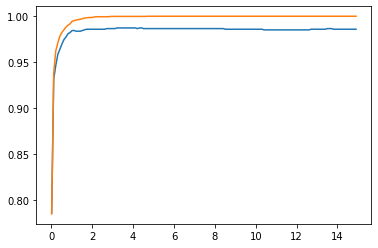

In [98]:
validation_curve_function(SVC(), x_train, y_train, "C", np.arange(0.01,15,0.1))

99.1% success rate.

#Random Forest


##All classes

In [99]:
df = Clean_dataframe(url)
df

,Gender,Age,Height,Weight,Family_overweight,FAVC,FCVC,NCP,CAEC,CH2O,SCC,FAF,TUE,CALC,Transportation,Obesity_level_category
0,1,21,1.62,64.0,1,0,2,3,2,2.0,0,0,1.00,3,0,Normal_Weight
1,1,21,1.52,56.0,1,0,3,3,2,3.0,1,3,0.00,2,0,Normal_Weight
2,0,23,1.80,77.0,1,0,2,3,2,2.0,0,2,1.00,1,0,Normal_Weight
3,0,27,1.80,87.0,0,0,3,3,2,2.0,0,2,0.00,1,1,Overweight_Level_I
4,0,22,1.78,89.8,0,0,2,1,2,2.0,0,0,0.00,2,0,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,1,20,1.71,131.4,1,1,3,3,2,1.7,0,2,0.91,2,0,Obesity_Type_III
2107,1,21,1.75,133.7,1,1,3,3,2,2.0,0,1,0.60,2,0,Obesity_Type_III
2108,1,22,1.75,133.7,1,1,3,3,2,2.1,0,1,0.65,2,0,Obesity_Type_III
2109,1,24,1.74,133.3,1,1,3,3,2,2.9,0,1,0.59,2,0,Obesity_Type_III


In [100]:
x=df.loc[:,df.columns!="Obesity_level_category"]
y=df.loc[:,df.columns=="Obesity_level_category"]

scaler=StandardScaler()
scaler.fit(x)
x_scaled=scaler.transform(x)

In [101]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.33)

In [102]:
RF = RandomForestClassifier()
parameters={"n_estimators" : [10, 100, 500], "max_features" : ['sqrt', 'log2']}

In [103]:
cross_val_function(RF, x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

[0.93992933 0.95759717 0.92579505 0.93286219 0.93971631]


In [104]:
grid_search = GridSearchCV(estimator=RF,
                           param_grid=parameters,
                           cv=5,
                           verbose=4)

In [105]:
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END max_features=sqrt, n_estimators=10;, score=0.912 total time=   0.0s
[CV 2/5] END max_features=sqrt, n_estimators=10;, score=0.940 total time=   0.0s
[CV 3/5] END max_features=sqrt, n_estimators=10;, score=0.898 total time=   0.0s
[CV 4/5] END max_features=sqrt, n_estimators=10;, score=0.905 total time=   0.0s
[CV 5/5] END max_features=sqrt, n_estimators=10;, score=0.890 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

[CV 1/5] END max_features=sqrt, n_estimators=100;, score=0.929 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END max_features=sqrt, n_estimators=100;, score=0.958 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END max_features=sqrt, n_estimators=100;, score=0.919 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END max_features=sqrt, n_estimators=100;, score=0.922 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END max_features=sqrt, n_estimators=100;, score=0.929 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END max_features=sqrt, n_estimators=500;, score=0.947 total time=   1.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END max_features=sqrt, n_estimators=500;, score=0.961 total time=   1.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END max_features=sqrt, n_estimators=500;, score=0.947 total time=   1.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END max_features=sqrt, n_estimators=500;, score=0.926 total time=   1.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END max_features=sqrt, n_estimators=500;, score=0.943 total time=   1.2s
[CV 1/5] END max_features=log2, n_estimators=10;, score=0.908 total time=   0.0s
[CV 2/5] END max_features=log2, n_estimators=10;, score=0.912 total time=   0.0s
[CV 3/5] END max_features=log2, n_estimators=10;, score=0.894 total time=   0.0s
[CV 4/5] END max_features=log2, n_estimators=10;, score=0.887 total time=   0.0s
[CV 5/5] END max_features=log2, n_estimators=10;, score=0.918 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

[CV 1/5] END max_features=log2, n_estimators=100;, score=0.940 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END max_features=log2, n_estimators=100;, score=0.954 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END max_features=log2, n_estimators=100;, score=0.940 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END max_features=log2, n_estimators=100;, score=0.933 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END max_features=log2, n_estimators=100;, score=0.936 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END max_features=log2, n_estimators=500;, score=0.940 total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END max_features=log2, n_estimators=500;, score=0.958 total time=   1.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END max_features=log2, n_estimators=500;, score=0.929 total time=   1.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END max_features=log2, n_estimators=500;, score=0.936 total time=   1.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END max_features=log2, n_estimators=500;, score=0.936 total time=   1.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_features': ['sqrt', 'log2'],
                         'n_estimators': [10, 100, 500]},
             verbose=4)

In [106]:
best_par = grid_search.best_params_
best_par

{'max_features': 'sqrt', 'n_estimators': 500}

In [107]:
RF = RandomForestClassifier(max_features = best_par["max_features"], n_estimators = best_par["n_estimators"])
model_RF_all = RF.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [108]:
pred = model_RF_all.predict(x_test)
pd.Series(pred).value_counts()

Obesity_Type_I         116
Obesity_Type_III       105
Obesity_Type_II        105
Normal_Weight          104
Overweight_Level_I      90
Insufficient_Weight     89
Overweight_Level_II     88
dtype: int64

In [109]:
pred = pd.DataFrame(pred)
pred.columns=y_test.columns

accuracy = np.where(pred.reset_index(drop=True)==y_test.reset_index(drop=True), 1, 0)
df_result_pred_test = pd.DataFrame(accuracy)
df_result_pred_test.columns = ["result"]

res_rf_all = 100*df_result_pred_test["result"].value_counts()[1]/len(df_result_pred_test["result"])
res_rf_all

93.25681492109038

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

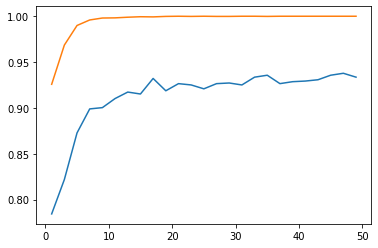

In [110]:
validation_curve_function(RandomForestClassifier(), x_train, y_train, "n_estimators", np.arange(1,50,2))

The Random Forest model allows us to determine at 93,4% whether a person is obese or not.

##Binary classification

In [111]:
obesity_level ={"Insufficient_Weight": "Not obese", "Normal_Weight": "Not obese", "Overweight_Level_I": "Not obese", "Overweight_Level_II": "Not obese", "Obesity_Type_I": "Obese", "Obesity_Type_II": "Obese", "Obesity_Type_III": "Obese"}

df["Obesity_level_category"] = df["Obesity_level_category"].map(obesity_level,na_action='ignore').apply(lambda x : str(x))

In [112]:
x=df.loc[:,df.columns!="Obesity_level_category"]
y=df.loc[:,df.columns=="Obesity_level_category"]

scaler=StandardScaler()
scaler.fit(x)
x_scaled=scaler.transform(x)

In [113]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.33)

In [114]:
RF = RandomForestClassifier()
parameters={"n_estimators" : [10, 100, 500], "max_features" : ['sqrt', 'log2']}

In [115]:
cross_val_function(RF, x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

[0.99293286 0.97879859 0.98586572 0.98939929 0.9964539 ]


In [116]:
grid_search = GridSearchCV(estimator=RF,
                           param_grid=parameters,
                           cv=5,
                           verbose=4)

In [117]:
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END max_features=sqrt, n_estimators=10;, score=0.979 total time=   0.0s
[CV 2/5] END max_features=sqrt, n_estimators=10;, score=0.979 total time=   0.0s
[CV 3/5] END max_features=sqrt, n_estimators=10;, score=0.972 total time=   0.0s
[CV 4/5] END max_features=sqrt, n_estimators=10;, score=0.989 total time=   0.0s
[CV 5/5] END max_features=sqrt, n_estimators=10;, score=0.989 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

[CV 1/5] END max_features=sqrt, n_estimators=100;, score=0.996 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END max_features=sqrt, n_estimators=100;, score=0.979 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END max_features=sqrt, n_estimators=100;, score=0.986 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END max_features=sqrt, n_estimators=100;, score=0.996 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END max_features=sqrt, n_estimators=100;, score=0.993 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END max_features=sqrt, n_estimators=500;, score=0.996 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END max_features=sqrt, n_estimators=500;, score=0.982 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END max_features=sqrt, n_estimators=500;, score=0.986 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END max_features=sqrt, n_estimators=500;, score=0.993 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END max_features=sqrt, n_estimators=500;, score=0.996 total time=   1.0s
[CV 1/5] END max_features=log2, n_estimators=10;, score=0.993 total time=   0.0s
[CV 2/5] END max_features=log2, n_estimators=10;, score=0.979 total time=   0.0s
[CV 3/5] END max_features=log2, n_estimators=10;, score=0.986 total time=   0.0s
[CV 4/5] END max_features=log2, n_estimators=10;, score=0.989 total time=   0.0s
[CV 5/5] END max_features=log2, n_estimators=10;, score=0.989 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

[CV 1/5] END max_features=log2, n_estimators=100;, score=0.996 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END max_features=log2, n_estimators=100;, score=0.982 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END max_features=log2, n_estimators=100;, score=0.986 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END max_features=log2, n_estimators=100;, score=0.993 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END max_features=log2, n_estimators=100;, score=0.996 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END max_features=log2, n_estimators=500;, score=0.996 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END max_features=log2, n_estimators=500;, score=0.979 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END max_features=log2, n_estimators=500;, score=0.989 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END max_features=log2, n_estimators=500;, score=0.993 total time=   1.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END max_features=log2, n_estimators=500;, score=0.996 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_features': ['sqrt', 'log2'],
                         'n_estimators': [10, 100, 500]},
             verbose=4)

In [118]:
best_par = grid_search.best_params_
best_par

{'max_features': 'sqrt', 'n_estimators': 500}

In [119]:
RF = RandomForestClassifier(max_features = best_par["max_features"], n_estimators = best_par["n_estimators"])
model_RF_bin = RF.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [120]:
pred = model_RF_bin.predict(x_test)
pd.Series(pred).value_counts()

Not obese    375
Obese        322
dtype: int64

In [121]:
pred = pd.DataFrame(pred)
pred.columns=y_test.columns

accuracy = np.where(pred.reset_index(drop=True)==y_test.reset_index(drop=True), 1, 0)
df_result_pred_test = pd.DataFrame(accuracy)
df_result_pred_test.columns = ["result"]

res_rf_bin = 100*df_result_pred_test["result"].value_counts()[1]/len(df_result_pred_test["result"])
res_rf_bin

99.28263988522238

The accuracy of the model is now 98,56%.

It has increased by about 5% using only the 2 class model.

#Gradient Boosting Classifier

##All classes

In [122]:
df = Clean_dataframe(url)
df

,Gender,Age,Height,Weight,Family_overweight,FAVC,FCVC,NCP,CAEC,CH2O,SCC,FAF,TUE,CALC,Transportation,Obesity_level_category
0,1,21,1.62,64.0,1,0,2,3,2,2.0,0,0,1.00,3,0,Normal_Weight
1,1,21,1.52,56.0,1,0,3,3,2,3.0,1,3,0.00,2,0,Normal_Weight
2,0,23,1.80,77.0,1,0,2,3,2,2.0,0,2,1.00,1,0,Normal_Weight
3,0,27,1.80,87.0,0,0,3,3,2,2.0,0,2,0.00,1,1,Overweight_Level_I
4,0,22,1.78,89.8,0,0,2,1,2,2.0,0,0,0.00,2,0,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,1,20,1.71,131.4,1,1,3,3,2,1.7,0,2,0.91,2,0,Obesity_Type_III
2107,1,21,1.75,133.7,1,1,3,3,2,2.0,0,1,0.60,2,0,Obesity_Type_III
2108,1,22,1.75,133.7,1,1,3,3,2,2.1,0,1,0.65,2,0,Obesity_Type_III
2109,1,24,1.74,133.3,1,1,3,3,2,2.9,0,1,0.59,2,0,Obesity_Type_III


In [123]:
x=df.loc[:,df.columns!="Obesity_level_category"]
y=df.loc[:,df.columns=="Obesity_level_category"]

scaler=StandardScaler()
scaler.fit(x)
x_scaled=scaler.transform(x)

In [124]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.33)

In [125]:
boost = GradientBoostingClassifier()
parameters={"n_estimators" : [10, 100, 500], "learning_rate" : [0.001, 0.01, 0.1]}

In [126]:
cross_val_function(boost, x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[0.97173145 0.9434629  0.97526502 0.94699647 0.9787234 ]


In [127]:
grid_search = GridSearchCV(estimator=boost,
                           param_grid=parameters,
                           cv=5,
                           verbose=4)

In [128]:
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END learning_rate=0.001, n_estimators=10;, score=0.177 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.001, n_estimators=10;, score=0.177 total time=   0.2s
[CV 3/5] END learning_rate=0.001, n_estimators=10;, score=0.177 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.001, n_estimators=10;, score=0.177 total time=   0.2s
[CV 5/5] END learning_rate=0.001, n_estimators=10;, score=0.177 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.001, n_estimators=100;, score=0.686 total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.001, n_estimators=100;, score=0.675 total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.001, n_estimators=100;, score=0.601 total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.001, n_estimators=100;, score=0.611 total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.001, n_estimators=100;, score=0.638 total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.001, n_estimators=500;, score=0.767 total time=   8.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.001, n_estimators=500;, score=0.788 total time=   8.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.001, n_estimators=500;, score=0.728 total time=   8.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.001, n_estimators=500;, score=0.802 total time=   8.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.001, n_estimators=500;, score=0.794 total time=   8.1s
[CV 1/5] END learning_rate=0.01, n_estimators=10;, score=0.686 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, n_estimators=10;, score=0.686 total time=   0.2s
[CV 3/5] END learning_rate=0.01, n_estimators=10;, score=0.601 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, n_estimators=10;, score=0.611 total time=   0.2s
[CV 5/5] END learning_rate=0.01, n_estimators=10;, score=0.638 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, n_estimators=100;, score=0.827 total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, n_estimators=100;, score=0.834 total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, n_estimators=100;, score=0.767 total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, n_estimators=100;, score=0.866 total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, n_estimators=100;, score=0.883 total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, n_estimators=500;, score=0.951 total time=   8.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, n_estimators=500;, score=0.912 total time=   8.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, n_estimators=500;, score=0.958 total time=   8.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, n_estimators=500;, score=0.943 total time=   8.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, n_estimators=500;, score=0.972 total time=   8.1s
[CV 1/5] END learning_rate=0.1, n_estimators=10;, score=0.830 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, n_estimators=10;, score=0.830 total time=   0.2s
[CV 3/5] END learning_rate=0.1, n_estimators=10;, score=0.809 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, n_estimators=10;, score=0.859 total time=   0.2s
[CV 5/5] END learning_rate=0.1, n_estimators=10;, score=0.865 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, n_estimators=100;, score=0.972 total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, n_estimators=100;, score=0.943 total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, n_estimators=100;, score=0.972 total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, n_estimators=100;, score=0.947 total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, n_estimators=100;, score=0.979 total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, n_estimators=500;, score=0.979 total time=   7.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, n_estimators=500;, score=0.940 total time=   7.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, n_estimators=500;, score=0.968 total time=   7.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, n_estimators=500;, score=0.954 total time=   7.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, n_estimators=500;, score=0.979 total time=   7.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'n_estimators': [10, 100, 500]},
             verbose=4)

In [129]:
best_par = grid_search.best_params_
best_par

{'learning_rate': 0.1, 'n_estimators': 500}

In [130]:
boost = GradientBoostingClassifier(learning_rate = best_par["learning_rate"], n_estimators = best_par["n_estimators"])
model_boost_all = boost.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [131]:
pred = model_boost_all.predict(x_test)
pd.Series(pred).value_counts()

Obesity_Type_III       112
Normal_Weight          102
Obesity_Type_I         100
Overweight_Level_II     99
Obesity_Type_II         96
Overweight_Level_I      96
Insufficient_Weight     92
dtype: int64

In [132]:
pred = pd.DataFrame(pred)
pred.columns=y_test.columns

accuracy = np.where(pred.reset_index(drop=True)==y_test.reset_index(drop=True), 1, 0)
df_result_pred_test = pd.DataFrame(accuracy)
df_result_pred_test.columns = ["result"]

res_boost_all = 100*df_result_pred_test["result"].value_counts()[1]/len(df_result_pred_test["result"])
res_boost_all

96.12625538020086

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

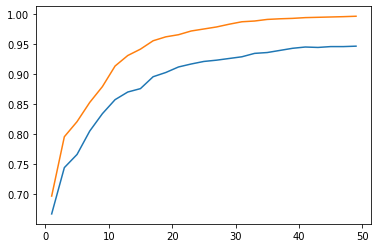

In [133]:
validation_curve_function(GradientBoostingClassifier(), x_train, y_train, "n_estimators", np.arange(1,50,2))

The Gradient Boosting Classifier allows us to determine at 95,2% whether a person is obese or not.

##Binary Classification

In [134]:
obesity_level ={"Insufficient_Weight": "Not obese", "Normal_Weight": "Not obese", "Overweight_Level_I": "Not obese", "Overweight_Level_II": "Not obese", "Obesity_Type_I": "Obese", "Obesity_Type_II": "Obese", "Obesity_Type_III": "Obese"}

df["Obesity_level_category"] = df["Obesity_level_category"].map(obesity_level,na_action='ignore').apply(lambda x : str(x))

In [135]:
x=df.loc[:,df.columns!="Obesity_level_category"]
y=df.loc[:,df.columns=="Obesity_level_category"]

scaler=StandardScaler()
scaler.fit(x)
x_scaled=scaler.transform(x)

In [136]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.33)

In [137]:
boost = GradientBoostingClassifier()
parameters={"n_estimators" : [10, 100, 500], "learning_rate" : [0.001, 0.01, 0.1], "subsample" : [0.5, 0.7, 1.0], "max_depth" : [3, 7, 9]}

In [138]:
cross_val_function(boost, x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[0.99293286 0.98233216 1.         0.98939929 1.        ]


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [139]:
grid_search = GridSearchCV(estimator=boost,
                           param_grid=parameters,
                           cv=5,
                           verbose=4)

In [140]:
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV 1/5] END learning_rate=0.001, max_depth=3, n_estimators=10, subsample=0.5;, score=0.548 total time=   0.0s
[CV 2/5] END learning_rate=0.001, max_depth=3, n_estimators=10, subsample=0.5;, score=0.548 total time=   0.0s
[CV 3/5] END learning_rate=0.001, max_depth=3, n_estimators=10, subsample=0.5;, score=0.548 total time=   0.0s
[CV 4/5] END learning_rate=0.001, max_depth=3, n_estimators=10, subsample=0.5;, score=0.544 total time=   0.0s
[CV 5/5] END learning_rate=0.001, max_depth=3, n_estimators=10, subsample=0.5;, score=0.546 total time=   0.0s
[CV 1/5] END learning_rate=0.001, max_depth=3, n_estimators=10, subsample=0.7;, score=0.548 total time=   0.0s
[CV 2/5] END learning_rate=0.001, max_depth=3, n_estimators=10, subsample=0.7;, score=0.548 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 3/5] END learning_rate=0.001, max_depth=3, n_estimators=10, subsample=0.7;, score=0.548 total time=   0.0s
[CV 4/5] END learning_rate=0.001, max_depth=3, n_estimators=10, subsample=0.7;, score=0.544 total time=   0.0s
[CV 5/5] END learning_rate=0.001, max_depth=3, n_estimators=10, subsample=0.7;, score=0.546 total time=   0.0s
[CV 1/5] END learning_rate=0.001, max_depth=3, n_estimators=10, subsample=1.0;, score=0.548 total time=   0.0s
[CV 2/5] END learning_rate=0.001, max_depth=3, n_estimators=10, subsample=1.0;, score=0.548 total time=   0.0s
[CV 3/5] END learning_rate=0.001, max_depth=3, n_estimators=10, subsample=1.0;, score=0.548 total time=   0.0s
[CV 4/5] END learning_rate=0.001, max_depth=3, n_estimators=10, subsample=1.0;, score=0.544 total time=   0.0s
[CV 5/5] END learning_rate=0.001, max_depth=3, n_estimators=10, subsample=1.0;, score=0.546 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 1/5] END learning_rate=0.001, max_depth=3, n_estimators=100, subsample=0.5;, score=0.912 total time=   0.2s
[CV 2/5] END learning_rate=0.001, max_depth=3, n_estimators=100, subsample=0.5;, score=0.894 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.001, max_depth=3, n_estimators=100, subsample=0.5;, score=0.880 total time=   0.2s
[CV 4/5] END learning_rate=0.001, max_depth=3, n_estimators=100, subsample=0.5;, score=0.929 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.001, max_depth=3, n_estimators=100, subsample=0.5;, score=0.908 total time=   0.2s
[CV 1/5] END learning_rate=0.001, max_depth=3, n_estimators=100, subsample=0.7;, score=0.912 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.001, max_depth=3, n_estimators=100, subsample=0.7;, score=0.901 total time=   0.2s
[CV 3/5] END learning_rate=0.001, max_depth=3, n_estimators=100, subsample=0.7;, score=0.890 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.001, max_depth=3, n_estimators=100, subsample=0.7;, score=0.936 total time=   0.2s
[CV 5/5] END learning_rate=0.001, max_depth=3, n_estimators=100, subsample=0.7;, score=0.911 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.001, max_depth=3, n_estimators=100, subsample=1.0;, score=0.926 total time=   0.2s
[CV 2/5] END learning_rate=0.001, max_depth=3, n_estimators=100, subsample=1.0;, score=0.915 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.001, max_depth=3, n_estimators=100, subsample=1.0;, score=0.898 total time=   0.2s
[CV 4/5] END learning_rate=0.001, max_depth=3, n_estimators=100, subsample=1.0;, score=0.940 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.001, max_depth=3, n_estimators=100, subsample=1.0;, score=0.936 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.001, max_depth=3, n_estimators=500, subsample=0.5;, score=0.975 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.001, max_depth=3, n_estimators=500, subsample=0.5;, score=0.961 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.001, max_depth=3, n_estimators=500, subsample=0.5;, score=0.982 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.001, max_depth=3, n_estimators=500, subsample=0.5;, score=0.989 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.001, max_depth=3, n_estimators=500, subsample=0.5;, score=0.979 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.001, max_depth=3, n_estimators=500, subsample=0.7;, score=0.982 total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.001, max_depth=3, n_estimators=500, subsample=0.7;, score=0.961 total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.001, max_depth=3, n_estimators=500, subsample=0.7;, score=0.989 total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.001, max_depth=3, n_estimators=500, subsample=0.7;, score=0.989 total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.001, max_depth=3, n_estimators=500, subsample=0.7;, score=0.982 total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.001, max_depth=3, n_estimators=500, subsample=1.0;, score=0.982 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.001, max_depth=3, n_estimators=500, subsample=1.0;, score=0.961 total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.001, max_depth=3, n_estimators=500, subsample=1.0;, score=0.989 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.001, max_depth=3, n_estimators=500, subsample=1.0;, score=0.982 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.001, max_depth=3, n_estimators=500, subsample=1.0;, score=0.982 total time=   1.0s
[CV 1/5] END learning_rate=0.001, max_depth=7, n_estimators=10, subsample=0.5;, score=0.548 total time=   0.0s
[CV 2/5] END learning_rate=0.001, max_depth=7, n_estimators=10, subsample=0.5;, score=0.548 total time=   0.0s
[CV 3/5] END learning_rate=0.001, max_depth=7, n_estimators=10, subsample=0.5;, score=0.548 total time=   0.0s
[CV 4/5] END learning_rate=0.001, max_depth=7, n_estimators=10, subsample=0.5;, score=0.544 total time=   0.0s
[CV 5/5] END learning_rate=0.001, max_depth=7, n_estimators=10, subsample=0.5;, score=0.546 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 1/5] END learning_rate=0.001, max_depth=7, n_estimators=10, subsample=0.7;, score=0.548 total time=   0.0s
[CV 2/5] END learning_rate=0.001, max_depth=7, n_estimators=10, subsample=0.7;, score=0.548 total time=   0.0s
[CV 3/5] END learning_rate=0.001, max_depth=7, n_estimators=10, subsample=0.7;, score=0.548 total time=   0.0s
[CV 4/5] END learning_rate=0.001, max_depth=7, n_estimators=10, subsample=0.7;, score=0.544 total time=   0.0s
[CV 5/5] END learning_rate=0.001, max_depth=7, n_estimators=10, subsample=0.7;, score=0.546 total time=   0.0s
[CV 1/5] END learning_rate=0.001, max_depth=7, n_estimators=10, subsample=1.0;, score=0.548 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 2/5] END learning_rate=0.001, max_depth=7, n_estimators=10, subsample=1.0;, score=0.548 total time=   0.0s
[CV 3/5] END learning_rate=0.001, max_depth=7, n_estimators=10, subsample=1.0;, score=0.548 total time=   0.0s
[CV 4/5] END learning_rate=0.001, max_depth=7, n_estimators=10, subsample=1.0;, score=0.544 total time=   0.0s
[CV 5/5] END learning_rate=0.001, max_depth=7, n_estimators=10, subsample=1.0;, score=0.546 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 1/5] END learning_rate=0.001, max_depth=7, n_estimators=100, subsample=0.5;, score=0.961 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.001, max_depth=7, n_estimators=100, subsample=0.5;, score=0.968 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.001, max_depth=7, n_estimators=100, subsample=0.5;, score=0.958 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.001, max_depth=7, n_estimators=100, subsample=0.5;, score=0.968 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.001, max_depth=7, n_estimators=100, subsample=0.5;, score=0.957 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.001, max_depth=7, n_estimators=100, subsample=0.7;, score=0.975 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.001, max_depth=7, n_estimators=100, subsample=0.7;, score=0.968 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.001, max_depth=7, n_estimators=100, subsample=0.7;, score=0.982 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.001, max_depth=7, n_estimators=100, subsample=0.7;, score=0.982 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.001, max_depth=7, n_estimators=100, subsample=0.7;, score=0.972 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.001, max_depth=7, n_estimators=100, subsample=1.0;, score=0.989 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.001, max_depth=7, n_estimators=100, subsample=1.0;, score=0.975 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.001, max_depth=7, n_estimators=100, subsample=1.0;, score=0.986 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.001, max_depth=7, n_estimators=100, subsample=1.0;, score=0.986 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.001, max_depth=7, n_estimators=100, subsample=1.0;, score=0.979 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.001, max_depth=7, n_estimators=500, subsample=0.5;, score=0.993 total time=   1.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.001, max_depth=7, n_estimators=500, subsample=0.5;, score=0.979 total time=   1.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.001, max_depth=7, n_estimators=500, subsample=0.5;, score=0.996 total time=   1.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.001, max_depth=7, n_estimators=500, subsample=0.5;, score=0.996 total time=   1.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.001, max_depth=7, n_estimators=500, subsample=0.5;, score=0.996 total time=   1.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.001, max_depth=7, n_estimators=500, subsample=0.7;, score=0.993 total time=   2.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.001, max_depth=7, n_estimators=500, subsample=0.7;, score=0.975 total time=   1.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.001, max_depth=7, n_estimators=500, subsample=0.7;, score=0.993 total time=   2.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.001, max_depth=7, n_estimators=500, subsample=0.7;, score=0.989 total time=   2.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.001, max_depth=7, n_estimators=500, subsample=0.7;, score=0.996 total time=   2.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.001, max_depth=7, n_estimators=500, subsample=1.0;, score=0.989 total time=   1.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.001, max_depth=7, n_estimators=500, subsample=1.0;, score=0.975 total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.001, max_depth=7, n_estimators=500, subsample=1.0;, score=0.986 total time=   1.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.001, max_depth=7, n_estimators=500, subsample=1.0;, score=0.989 total time=   1.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.001, max_depth=7, n_estimators=500, subsample=1.0;, score=0.982 total time=   1.6s
[CV 1/5] END learning_rate=0.001, max_depth=9, n_estimators=10, subsample=0.5;, score=0.548 total time=   0.0s
[CV 2/5] END learning_rate=0.001, max_depth=9, n_estimators=10, subsample=0.5;, score=0.548 total time=   0.0s
[CV 3/5] END learning_rate=0.001, max_depth=9, n_estimators=10, subsample=0.5;, score=0.548 total time=   0.0s
[CV 4/5] END learning_rate=0.001, max_depth=9, n_estimators=10, subsample=0.5;, score=0.544 total time=   0.0s
[CV 5/5] END learning_rate=0.001, max_depth=9, n_estimators=10, subsample=0.5;, score=0.546 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 1/5] END learning_rate=0.001, max_depth=9, n_estimators=10, subsample=0.7;, score=0.548 total time=   0.0s
[CV 2/5] END learning_rate=0.001, max_depth=9, n_estimators=10, subsample=0.7;, score=0.548 total time=   0.0s
[CV 3/5] END learning_rate=0.001, max_depth=9, n_estimators=10, subsample=0.7;, score=0.548 total time=   0.0s
[CV 4/5] END learning_rate=0.001, max_depth=9, n_estimators=10, subsample=0.7;, score=0.544 total time=   0.0s
[CV 5/5] END learning_rate=0.001, max_depth=9, n_estimators=10, subsample=0.7;, score=0.546 total time=   0.0s
[CV 1/5] END learning_rate=0.001, max_depth=9, n_estimators=10, subsample=1.0;, score=0.548 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 2/5] END learning_rate=0.001, max_depth=9, n_estimators=10, subsample=1.0;, score=0.548 total time=   0.0s
[CV 3/5] END learning_rate=0.001, max_depth=9, n_estimators=10, subsample=1.0;, score=0.548 total time=   0.0s
[CV 4/5] END learning_rate=0.001, max_depth=9, n_estimators=10, subsample=1.0;, score=0.544 total time=   0.0s
[CV 5/5] END learning_rate=0.001, max_depth=9, n_estimators=10, subsample=1.0;, score=0.546 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 1/5] END learning_rate=0.001, max_depth=9, n_estimators=100, subsample=0.5;, score=0.961 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.001, max_depth=9, n_estimators=100, subsample=0.5;, score=0.972 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.001, max_depth=9, n_estimators=100, subsample=0.5;, score=0.940 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.001, max_depth=9, n_estimators=100, subsample=0.5;, score=0.968 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.001, max_depth=9, n_estimators=100, subsample=0.5;, score=0.957 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.001, max_depth=9, n_estimators=100, subsample=0.7;, score=0.975 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.001, max_depth=9, n_estimators=100, subsample=0.7;, score=0.968 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.001, max_depth=9, n_estimators=100, subsample=0.7;, score=0.989 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.001, max_depth=9, n_estimators=100, subsample=0.7;, score=0.986 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.001, max_depth=9, n_estimators=100, subsample=0.7;, score=0.975 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.001, max_depth=9, n_estimators=100, subsample=1.0;, score=0.989 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.001, max_depth=9, n_estimators=100, subsample=1.0;, score=0.975 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.001, max_depth=9, n_estimators=100, subsample=1.0;, score=0.986 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.001, max_depth=9, n_estimators=100, subsample=1.0;, score=0.986 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.001, max_depth=9, n_estimators=100, subsample=1.0;, score=0.979 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.001, max_depth=9, n_estimators=500, subsample=0.5;, score=0.996 total time=   2.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.001, max_depth=9, n_estimators=500, subsample=0.5;, score=0.979 total time=   2.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.001, max_depth=9, n_estimators=500, subsample=0.5;, score=0.996 total time=   2.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.001, max_depth=9, n_estimators=500, subsample=0.5;, score=0.996 total time=   2.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.001, max_depth=9, n_estimators=500, subsample=0.5;, score=0.996 total time=   2.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.001, max_depth=9, n_estimators=500, subsample=0.7;, score=0.993 total time=   2.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.001, max_depth=9, n_estimators=500, subsample=0.7;, score=0.975 total time=   2.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.001, max_depth=9, n_estimators=500, subsample=0.7;, score=0.993 total time=   2.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.001, max_depth=9, n_estimators=500, subsample=0.7;, score=0.989 total time=   2.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.001, max_depth=9, n_estimators=500, subsample=0.7;, score=0.996 total time=   2.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.001, max_depth=9, n_estimators=500, subsample=1.0;, score=0.989 total time=   1.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.001, max_depth=9, n_estimators=500, subsample=1.0;, score=0.975 total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.001, max_depth=9, n_estimators=500, subsample=1.0;, score=0.986 total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.001, max_depth=9, n_estimators=500, subsample=1.0;, score=0.989 total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.001, max_depth=9, n_estimators=500, subsample=1.0;, score=0.982 total time=   1.6s
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=10, subsample=0.5;, score=0.912 total time=   0.0s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=10, subsample=0.5;, score=0.908 total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=10, subsample=0.5;, score=0.894 total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=10, subsample=0.5;, score=0.936 total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=10, subsample=0.5;, score=0.901 total time=   0.0s
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=10, subsample=0.7;, score=0.919 total time=   0.0s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=10, subsample=0.7;, score=0.908 total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=10, subsample=0.7;, score=0.894 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=10, subsample=0.7;, score=0.940 total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=10, subsample=0.7;, score=0.918 total time=   0.0s
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=10, subsample=1.0;, score=0.926 total time=   0.0s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=10, subsample=1.0;, score=0.915 total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=10, subsample=1.0;, score=0.898 total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=10, subsample=1.0;, score=0.940 total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=10, subsample=1.0;, score=0.936 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5;, score=0.982 total time=   0.2s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5;, score=0.961 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5;, score=0.996 total time=   0.2s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5;, score=0.993 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5;, score=0.986 total time=   0.2s
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7;, score=0.982 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7;, score=0.961 total time=   0.2s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7;, score=0.996 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7;, score=0.993 total time=   0.2s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7;, score=0.982 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0;, score=0.982 total time=   0.2s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0;, score=0.961 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0;, score=0.993 total time=   0.2s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0;, score=0.993 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0;, score=0.982 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.5;, score=0.996 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.5;, score=0.982 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.5;, score=0.993 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.5;, score=0.993 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.5;, score=1.000 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.7;, score=0.996 total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.7;, score=0.982 total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.7;, score=0.996 total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.7;, score=0.993 total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.7;, score=1.000 total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=500, subsample=1.0;, score=0.989 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=500, subsample=1.0;, score=0.982 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=500, subsample=1.0;, score=1.000 total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=500, subsample=1.0;, score=0.993 total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=500, subsample=1.0;, score=1.000 total time=   0.9s
[CV 1/5] END learning_rate=0.01, max_depth=7, n_estimators=10, subsample=0.5;, score=0.958 total time=   0.0s
[CV 2/5] END learning_rate=0.01, max_depth=7, n_estimators=10, subsample=0.5;, score=0.951 total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=7, n_estimators=10, subsample=0.5;, score=0.954 total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=7, n_estimators=10, subsample=0.5;, score=0.965 total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=7, n_estimators=10, subsample=0.5;, score=0.957 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 1/5] END learning_rate=0.01, max_depth=7, n_estimators=10, subsample=0.7;, score=0.965 total time=   0.0s
[CV 2/5] END learning_rate=0.01, max_depth=7, n_estimators=10, subsample=0.7;, score=0.968 total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=7, n_estimators=10, subsample=0.7;, score=0.979 total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=7, n_estimators=10, subsample=0.7;, score=0.979 total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=7, n_estimators=10, subsample=0.7;, score=0.972 total time=   0.0s
[CV 1/5] END learning_rate=0.01, max_depth=7, n_estimators=10, subsample=1.0;, score=0.989 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 2/5] END learning_rate=0.01, max_depth=7, n_estimators=10, subsample=1.0;, score=0.975 total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=7, n_estimators=10, subsample=1.0;, score=0.986 total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=7, n_estimators=10, subsample=1.0;, score=0.986 total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=7, n_estimators=10, subsample=1.0;, score=0.979 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 1/5] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.5;, score=0.993 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.5;, score=0.979 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.5;, score=0.996 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.5;, score=0.996 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.5;, score=0.996 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.7;, score=0.993 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.7;, score=0.975 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.7;, score=0.996 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.7;, score=0.986 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.7;, score=0.996 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0;, score=0.989 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0;, score=0.975 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0;, score=0.989 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0;, score=0.982 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0;, score=0.982 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, max_depth=7, n_estimators=500, subsample=0.5;, score=0.996 total time=   1.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=7, n_estimators=500, subsample=0.5;, score=0.982 total time=   1.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=7, n_estimators=500, subsample=0.5;, score=1.000 total time=   1.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=7, n_estimators=500, subsample=0.5;, score=0.993 total time=   1.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=7, n_estimators=500, subsample=0.5;, score=1.000 total time=   1.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, max_depth=7, n_estimators=500, subsample=0.7;, score=0.993 total time=   2.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=7, n_estimators=500, subsample=0.7;, score=0.979 total time=   1.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=7, n_estimators=500, subsample=0.7;, score=0.996 total time=   2.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=7, n_estimators=500, subsample=0.7;, score=0.993 total time=   2.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=7, n_estimators=500, subsample=0.7;, score=0.996 total time=   2.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, max_depth=7, n_estimators=500, subsample=1.0;, score=0.989 total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=7, n_estimators=500, subsample=1.0;, score=0.975 total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=7, n_estimators=500, subsample=1.0;, score=0.989 total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=7, n_estimators=500, subsample=1.0;, score=0.982 total time=   1.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=7, n_estimators=500, subsample=1.0;, score=0.982 total time=   1.4s
[CV 1/5] END learning_rate=0.01, max_depth=9, n_estimators=10, subsample=0.5;, score=0.951 total time=   0.0s
[CV 2/5] END learning_rate=0.01, max_depth=9, n_estimators=10, subsample=0.5;, score=0.961 total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=9, n_estimators=10, subsample=0.5;, score=0.972 total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=9, n_estimators=10, subsample=0.5;, score=0.972 total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=9, n_estimators=10, subsample=0.5;, score=0.947 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 1/5] END learning_rate=0.01, max_depth=9, n_estimators=10, subsample=0.7;, score=0.975 total time=   0.0s
[CV 2/5] END learning_rate=0.01, max_depth=9, n_estimators=10, subsample=0.7;, score=0.972 total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=9, n_estimators=10, subsample=0.7;, score=0.989 total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=9, n_estimators=10, subsample=0.7;, score=0.965 total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=9, n_estimators=10, subsample=0.7;, score=0.965 total time=   0.0s
[CV 1/5] END learning_rate=0.01, max_depth=9, n_estimators=10, subsample=1.0;, score=0.989 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 2/5] END learning_rate=0.01, max_depth=9, n_estimators=10, subsample=1.0;, score=0.975 total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=9, n_estimators=10, subsample=1.0;, score=0.986 total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=9, n_estimators=10, subsample=1.0;, score=0.986 total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=9, n_estimators=10, subsample=1.0;, score=0.979 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 1/5] END learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.5;, score=0.993 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.5;, score=0.979 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.5;, score=0.996 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.5;, score=0.996 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.5;, score=0.996 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.7;, score=0.993 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.7;, score=0.975 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.7;, score=0.996 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.7;, score=0.986 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.7;, score=0.993 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, max_depth=9, n_estimators=100, subsample=1.0;, score=0.989 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=9, n_estimators=100, subsample=1.0;, score=0.975 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=9, n_estimators=100, subsample=1.0;, score=0.989 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=9, n_estimators=100, subsample=1.0;, score=0.989 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=9, n_estimators=100, subsample=1.0;, score=0.982 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, max_depth=9, n_estimators=500, subsample=0.5;, score=0.996 total time=   2.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=9, n_estimators=500, subsample=0.5;, score=0.982 total time=   2.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=9, n_estimators=500, subsample=0.5;, score=1.000 total time=   2.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=9, n_estimators=500, subsample=0.5;, score=0.996 total time=   2.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=9, n_estimators=500, subsample=0.5;, score=1.000 total time=   2.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, max_depth=9, n_estimators=500, subsample=0.7;, score=0.993 total time=   2.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=9, n_estimators=500, subsample=0.7;, score=0.979 total time=   2.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=9, n_estimators=500, subsample=0.7;, score=1.000 total time=   2.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=9, n_estimators=500, subsample=0.7;, score=0.993 total time=   2.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=9, n_estimators=500, subsample=0.7;, score=0.996 total time=   2.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, max_depth=9, n_estimators=500, subsample=1.0;, score=0.986 total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=9, n_estimators=500, subsample=1.0;, score=0.975 total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=9, n_estimators=500, subsample=1.0;, score=0.989 total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=9, n_estimators=500, subsample=1.0;, score=0.989 total time=   1.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=9, n_estimators=500, subsample=1.0;, score=0.982 total time=   1.4s
[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.5;, score=0.986 total time=   0.0s
[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.5;, score=0.961 total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.5;, score=0.989 total time=   0.0s
[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.5;, score=0.965 total time=   0.0s
[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.5;, score=0.982 total time=   0.0s
[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.7;, score=0.982 total time=   0.0s
[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.7;, score=0.965 total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.7;, score=0.993 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.7;, score=0.989 total time=   0.0s
[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.7;, score=0.982 total time=   0.0s
[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=10, subsample=1.0;, score=0.982 total time=   0.0s
[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=10, subsample=1.0;, score=0.961 total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=10, subsample=1.0;, score=0.993 total time=   0.0s
[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=10, subsample=1.0;, score=0.993 total time=   0.0s
[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=10, subsample=1.0;, score=0.982 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5;, score=0.993 total time=   0.2s
[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5;, score=0.982 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5;, score=0.996 total time=   0.2s
[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5;, score=0.989 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5;, score=1.000 total time=   0.2s
[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7;, score=0.993 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7;, score=0.982 total time=   0.2s
[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7;, score=0.996 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7;, score=0.996 total time=   0.2s
[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7;, score=1.000 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0;, score=0.993 total time=   0.2s
[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0;, score=0.982 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0;, score=1.000 total time=   0.2s
[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0;, score=0.989 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0;, score=1.000 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.5;, score=0.993 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.5;, score=0.982 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.5;, score=0.996 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.5;, score=0.996 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.5;, score=1.000 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.7;, score=0.993 total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.7;, score=0.982 total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.7;, score=1.000 total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.7;, score=0.996 total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.7;, score=1.000 total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=500, subsample=1.0;, score=0.993 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=500, subsample=1.0;, score=0.986 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=500, subsample=1.0;, score=1.000 total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=500, subsample=1.0;, score=0.989 total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=500, subsample=1.0;, score=1.000 total time=   0.9s
[CV 1/5] END learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.5;, score=0.986 total time=   0.0s
[CV 2/5] END learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.5;, score=0.979 total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.5;, score=0.996 total time=   0.0s
[CV 4/5] END learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.5;, score=0.996 total time=   0.0s
[CV 5/5] END learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.5;, score=0.996 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 1/5] END learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.7;, score=0.993 total time=   0.1s
[CV 2/5] END learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.7;, score=0.975 total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.7;, score=0.993 total time=   0.0s
[CV 4/5] END learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.7;, score=0.986 total time=   0.0s
[CV 5/5] END learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.7;, score=0.996 total time=   0.0s
[CV 1/5] END learning_rate=0.1, max_depth=7, n_estimators=10, subsample=1.0;, score=0.989 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 2/5] END learning_rate=0.1, max_depth=7, n_estimators=10, subsample=1.0;, score=0.975 total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=7, n_estimators=10, subsample=1.0;, score=0.986 total time=   0.0s
[CV 4/5] END learning_rate=0.1, max_depth=7, n_estimators=10, subsample=1.0;, score=0.982 total time=   0.0s
[CV 5/5] END learning_rate=0.1, max_depth=7, n_estimators=10, subsample=1.0;, score=0.982 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 1/5] END learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.5;, score=0.993 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.5;, score=0.982 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.5;, score=1.000 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.5;, score=0.996 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.5;, score=1.000 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.7;, score=0.993 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.7;, score=0.982 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.7;, score=0.993 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.7;, score=0.993 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.7;, score=1.000 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0;, score=0.986 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0;, score=0.975 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0;, score=0.986 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0;, score=0.989 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0;, score=0.982 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, max_depth=7, n_estimators=500, subsample=0.5;, score=0.996 total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=7, n_estimators=500, subsample=0.5;, score=0.993 total time=   1.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=7, n_estimators=500, subsample=0.5;, score=0.993 total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=7, n_estimators=500, subsample=0.5;, score=0.986 total time=   1.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=7, n_estimators=500, subsample=0.5;, score=1.000 total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, max_depth=7, n_estimators=500, subsample=0.7;, score=0.996 total time=   1.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=7, n_estimators=500, subsample=0.7;, score=0.982 total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=7, n_estimators=500, subsample=0.7;, score=0.996 total time=   1.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=7, n_estimators=500, subsample=0.7;, score=0.996 total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=7, n_estimators=500, subsample=0.7;, score=1.000 total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, max_depth=7, n_estimators=500, subsample=1.0;, score=0.989 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=7, n_estimators=500, subsample=1.0;, score=0.975 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=7, n_estimators=500, subsample=1.0;, score=0.986 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=7, n_estimators=500, subsample=1.0;, score=0.989 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=7, n_estimators=500, subsample=1.0;, score=0.982 total time=   0.6s
[CV 1/5] END learning_rate=0.1, max_depth=9, n_estimators=10, subsample=0.5;, score=0.993 total time=   0.0s
[CV 2/5] END learning_rate=0.1, max_depth=9, n_estimators=10, subsample=0.5;, score=0.982 total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=9, n_estimators=10, subsample=0.5;, score=0.996 total time=   0.0s
[CV 4/5] END learning_rate=0.1, max_depth=9, n_estimators=10, subsample=0.5;, score=1.000 total time=   0.0s
[CV 5/5] END learning_rate=0.1, max_depth=9, n_estimators=10, subsample=0.5;, score=0.996 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 1/5] END learning_rate=0.1, max_depth=9, n_estimators=10, subsample=0.7;, score=0.993 total time=   0.1s
[CV 2/5] END learning_rate=0.1, max_depth=9, n_estimators=10, subsample=0.7;, score=0.975 total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=9, n_estimators=10, subsample=0.7;, score=0.996 total time=   0.0s
[CV 4/5] END learning_rate=0.1, max_depth=9, n_estimators=10, subsample=0.7;, score=0.989 total time=   0.0s
[CV 5/5] END learning_rate=0.1, max_depth=9, n_estimators=10, subsample=0.7;, score=0.982 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 1/5] END learning_rate=0.1, max_depth=9, n_estimators=10, subsample=1.0;, score=0.989 total time=   0.0s
[CV 2/5] END learning_rate=0.1, max_depth=9, n_estimators=10, subsample=1.0;, score=0.975 total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=9, n_estimators=10, subsample=1.0;, score=0.989 total time=   0.0s
[CV 4/5] END learning_rate=0.1, max_depth=9, n_estimators=10, subsample=1.0;, score=0.989 total time=   0.0s
[CV 5/5] END learning_rate=0.1, max_depth=9, n_estimators=10, subsample=1.0;, score=0.982 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 1/5] END learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.5;, score=0.996 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.5;, score=0.979 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.5;, score=0.996 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.5;, score=0.993 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.5;, score=1.000 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.7;, score=0.996 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.7;, score=0.979 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.7;, score=1.000 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.7;, score=0.993 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.7;, score=1.000 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, max_depth=9, n_estimators=100, subsample=1.0;, score=0.986 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=9, n_estimators=100, subsample=1.0;, score=0.975 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=9, n_estimators=100, subsample=1.0;, score=0.986 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=9, n_estimators=100, subsample=1.0;, score=0.989 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=9, n_estimators=100, subsample=1.0;, score=0.982 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, max_depth=9, n_estimators=500, subsample=0.5;, score=0.996 total time=   1.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=9, n_estimators=500, subsample=0.5;, score=0.989 total time=   1.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=9, n_estimators=500, subsample=0.5;, score=0.989 total time=   1.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=9, n_estimators=500, subsample=0.5;, score=0.989 total time=   1.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=9, n_estimators=500, subsample=0.5;, score=1.000 total time=   1.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, max_depth=9, n_estimators=500, subsample=0.7;, score=0.996 total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=9, n_estimators=500, subsample=0.7;, score=0.982 total time=   1.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=9, n_estimators=500, subsample=0.7;, score=1.000 total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=9, n_estimators=500, subsample=0.7;, score=0.993 total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=9, n_estimators=500, subsample=0.7;, score=1.000 total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, max_depth=9, n_estimators=500, subsample=1.0;, score=0.989 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=9, n_estimators=500, subsample=1.0;, score=0.975 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=9, n_estimators=500, subsample=1.0;, score=0.986 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=9, n_estimators=500, subsample=1.0;, score=0.989 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=9, n_estimators=500, subsample=1.0;, score=0.982 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [3, 7, 9], 'n_estimators': [10, 100, 500],
                         'subsample': [0.5, 0.7, 1.0]},
             verbose=4)

In [141]:
best_par = grid_search.best_params_
best_par

{'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 500, 'subsample': 0.5}

In [142]:
boost = GradientBoostingClassifier(learning_rate = best_par["learning_rate"], n_estimators = best_par["n_estimators"], max_depth = best_par["max_depth"], subsample = best_par["subsample"])
model_boost_bin = boost.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [143]:
pred = model_boost_bin.predict(x_test)
pd.Series(pred).value_counts()

Not obese    366
Obese        331
dtype: int64

In [144]:
pred = pd.DataFrame(pred)
pred.columns=y_test.columns

accuracy = np.where(pred.reset_index(drop=True)==y_test.reset_index(drop=True), 1, 0)
df_result_pred_test = pd.DataFrame(accuracy)
df_result_pred_test.columns = ["result"]

res_boost_bin = 100*df_result_pred_test["result"].value_counts()[1]/len(df_result_pred_test["result"])
res_boost_bin

99.13916786226686

The accuracy of the model is now 99.5%.

It has increased by about 4% using only the 2 class model.

#Comparaison of the models

After processing all our models, we are going to create a dataframe to group all models result and in fact more visualization about their accuracy.

In [145]:
res_all = [res_lda_all, res_knn_all, res_svm_all, res_rf_all, res_boost_all]
res_bin = [res_lda_bin, res_knn_bin, res_svm_bin, res_rf_bin, res_boost_bin]
results = np.array([res_all, res_bin])

names_models = ["LDA","Knn","SVM","RandomForest","Boosting"]
compare_models = pd.DataFrame(results, index=["Prediction of IMC level category","Prediction of Obesity"], columns = names_models)
for c in compare_models.columns:
  compare_models[c] = compare_models[c].apply(lambda x : round(float(x),2))
compare_models

,LDA,Knn,SVM,RandomForest,Boosting
Prediction of IMC level category,83.07,85.65,92.25,93.26,96.13
Prediction of Obesity,94.98,96.41,98.71,99.28,99.14


Next, we plot the differents result to find the best model.

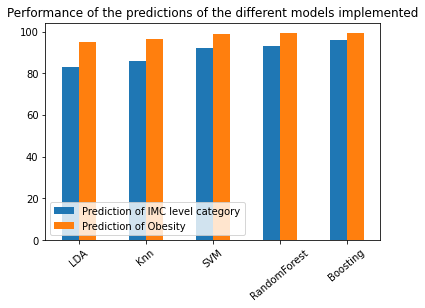

In [146]:
compare_models.T.plot(kind="bar",rot=40)
plt.title("Performance of the predictions of the different models implemented")
plt.legend(loc='lower left')

#Flask

##Conversion of the input information into a dataframe according to the different models 

Here is a function that allows us to transform the data from the form on the web page into data ready to be sent to the prediction function of our different Machine Learning models.

In [147]:
def Create_data_for_prediction(data):

  df = pd.read_csv(url)
  df.dropna(inplace=True)

  col_names = ["Gender", "Age", "Height", "Weight", "Family_overweight", "FAVC", "FCVC", "NCP", "CAEC", "Smoke", "CH2O", "SCC", "FAF", "TUE", "CALC", "Transportation", "Obesity_level_category"]
  df.columns = col_names

  df = df.append({"Gender" : data[0], "Age" : data[1], "Height": data[2], "Weight": data[3], "Family_overweight": data[4], "FAVC": data[5], "FCVC": data[6], "NCP": data[7], "CAEC": data[8], "Smoke": data[9], "CH2O": data[10], "SCC": data[11], "FAF": data[12], "TUE": data[13], "CALC": data[14], "Transportation": data[15], "Obesity_level_category": data[16] },ignore_index=True)

  df["Gender"] = df["Gender"].apply(lambda x : 1 if x=="Female" else 0)
  df["Age"] = df["Age"].apply(lambda x : int(x))
  df["Height"] = df["Height"].apply(lambda x : round(float(x),2))
  df["Weight"] = df["Weight"].apply(lambda x : round(float(x),1))
  df["Family_overweight"] = df["Family_overweight"].apply(lambda x : 1 if x=="yes" else 0)
  df["FAVC"] = df["FAVC"].apply(lambda x : 1 if x=="yes" else 0)
  df["FCVC"] = df["FCVC"].apply(lambda x : int(round(int(x),0)))
  df["NCP"] = df["NCP"].apply(lambda x : int(round(int(x),0)))
  df["CAEC"], unique_CAEC = pd.factorize(df["CAEC"], sort=True)
  df["Smoke"] = df["Smoke"].apply(lambda x : 1 if x=="yes" else 0)
  df["CH2O"] = df["CH2O"].apply(lambda x : round(int(x),1))
  df["SCC"] = df["SCC"].apply(lambda x : 1 if x=="yes" else 0)
  df["FAF"] = df["FAF"].apply(lambda x : int(round(int(x),0)))
  df["TUE"] = df["TUE"].apply(lambda x : round(int(x),2))
  df["CALC"], unique_CALC = pd.factorize(df["CALC"], sort=True)

  transportation ={"Automobile": 1, "Bike": 2, "Motorbike": 3, "Public_Transportation": 4, "Walking": 5}

  df["Transportation"] = df["Transportation"].map(transportation,na_action='ignore').apply(lambda x : int(x))

  df['Transportation']=np.where(df['Transportation']==1,0,df['Transportation']) #Automobile
  df['Transportation']=np.where(df['Transportation']==3,0,df['Transportation']) #Motorbike
  df['Transportation']=np.where(df['Transportation']==4,0,df['Transportation']) #Public transportation

  df['Transportation']=np.where(df['Transportation']==2,1,df['Transportation']) #Bike
  df['Transportation']=np.where(df['Transportation']==5,1,df['Transportation']) #Walking

  #df.drop(['Weight'],axis = 1, inplace = True)
  df.drop(['Smoke'],axis = 1, inplace = True)

  x=df.loc[:,df.columns!="Obesity_level_category"]

  scaler=StandardScaler()
  scaler.fit(x)
  x_scaled=scaler.transform(x)

  return np.array(list(x_scaled)[2111],ndmin=2)

##Pip install and packages

In [148]:
!pip install flask-ngrok
!pip install pyngrok==4.1.1
!ngrok authtoken 22jg9dgfJ2Vrf9hIs8I8fppLe24_4vre3wAhAg3T7F9ArM2Nr

  Created wheel for pyngrok: filename=pyngrok-4.1.1-py3-none-any.whl size=15984 sha256=07756b02d64b5b99f2afd715bef05b9639cc74701d8b67f47b5cdb506c22629c
  Stored in directory: /root/.cache/pip/wheels/b1/d9/12/045a042fee3127dc40ba6f5df2798aa2df38c414bf533ca765
Successfully built pyngrok
Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [149]:
import pickle
from os import name
from flask_ngrok import run_with_ngrok
from flask import Flask, request, render_template, redirect, url_for

Saving our models in .pkl binary format for the Flask application.

In [152]:
pickle.dump(model_RF_all, open('/content/models/model_RF_all.pkl','wb'))
pickle.dump(model_RF_bin, open('/content/models/model_RF_bin.pkl','wb'))

pickle.dump(model_boost_all, open('/content/models/model_boost_all.pkl', 'wb'))
pickle.dump(model_boost_bin, open('/content/model_boost_bin.pkl', 'wb'))

pickle.dump(model_knn_all, open('/content/models/model_knn_all.pkl','wb'))
pickle.dump(model_knn_bin, open('/content/models/model_knn_bin.pkl','wb'))

pickle.dump(model_svm_all, open('/content/models/model_svm_all.pkl','wb'))
pickle.dump(model_svm_bin, open('/content/models/model_svm_bin.pkl','wb'))

pickle.dump(model_lda, open('/content/models/model_lda.pkl','wb'))
pickle.dump(model_lg, open('/content/models/model_lg.pkl','wb'))

##App

Our application consists of 5 pages:

-The home page, which allows you to choose which model to use and which prediction we want to make (whether a person is obese or not, or whether we want to obtain directly a BMI range for the individual.

-Two pages displaying a form to be filled in with information about the different variables in our dataset (one for each type of prediction)

-Two pages displaying the predictions made by our algorithms (with the possibility of filling in the form again)

In [156]:
app = Flask(__name__, template_folder='/content', static_folder='/content/static')

run_with_ngrok(app)

model_RF_all = pickle.load(open('/content/models/model_RF_all.pkl', 'rb'))
model_RF_bin = pickle.load(open('/content/models/model_RF_bin.pkl', 'rb'))

model_boost_all = pickle.load(open('/content/models/model_boost_all.pkl', 'rb'))
model_boost_bin = pickle.load(open('/content/models/model_boost_bin.pkl', 'rb'))

model_knn_all = pickle.load(open('/content/models/model_knn_all.pkl', 'rb'))
model_knn_bin = pickle.load(open('/content/models/model_knn_bin.pkl', 'rb'))

model_svm_all = pickle.load(open('/content/models/model_svm_all.pkl', 'rb'))
model_svm_bin = pickle.load(open('/content/models/model_svm_bin.pkl', 'rb'))

model_lda = pickle.load(open('/content/models/model_lda.pkl', 'rb'))
model_lg = pickle.load(open('/content/models/model_lg.pkl', 'rb'))

my_best_model_all = model_RF_all
my_best_model_bin = model_RF_bin

@app.route('/')
def home():
    return render_template("index_accueil.html", url='models.JPG')

@app.route('/Binary_prediction',methods=['POST'])
def Binary_prediction():

  input = [x for x in request.form.values()]
  if(input[0]=="LDA"):
    my_best_model_bin=model_lg
  else:
    if(input[0]=="Knn"):
      my_best_model_bin=model_knn_bin
    else:
      if(input[0]=="SVM"):
        my_best_model_bin=model_svm_bin
      else:
        if(input[0]=="Boosting"):
          my_best_model_bin=model_boost_bin

  return render_template("binary_classification.html", output="Vous avez choisi le modèle " + input[0] + " qui a une précision de : " + str(compare_models.loc['Prediction of Obesity',input[0]]) + "%")

@app.route('/All_classes_prediction',methods=['POST'])
def All_classes_prediction():

  input=[x for x in request.form.values()]
  if(input[0]=="LDA"):
    my_best_model_all=model_lda
  else:
    if(input[0]=="Knn"):
      my_best_model_all=model_knn_all
    else:
      if(input[0]=="SVM"):
        my_best_model_all=model_svm_all
      else:
        if(input[0]=="Boosting"):
          my_best_model_all=model_boost_all 
  return render_template("all_classes.html",output="Vous avez choisi le modèle " + input[0] + " qui a une précision de : " + str(compare_models.loc['Prediction of IMC level category',input[0]]) + "%")

@app.route('/get_binary_prediction',methods=['POST'])
def get_binary_prediction():    

    input = [x for x in request.form.values()]
    input.append("")

    x = Create_data_for_prediction(input)

    prediction = my_best_model_bin.predict(x)

    return render_template("binary_result.html", output='Predicted obesity level category : {}'.format(prediction))

@app.route('/get_all_classes_prediction',methods=['POST'])
def get_all_classes_prediction():    

    input = [x for x in request.form.values()]
    input.append("")

    x = Create_data_for_prediction(input)

    prediction = my_best_model_all.predict(x)

    return render_template("all_classes_result.html", output='Predicted obesity level category : {}'.format(prediction))

app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://867a-34-134-229-58.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [05/Jan/2022 21:52:51] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [05/Jan/2022 21:52:51] "GET /static/css/style.css HTTP/1.1" 200 -
127.0.0.1 - - [05/Jan/2022 21:52:51] "GET /static/models.JPG HTTP/1.1" 200 -
127.0.0.1 - - [05/Jan/2022 21:52:53] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [05/Jan/2022 21:52:53] "GET /static/css/style.css HTTP/1.1" 200 -
127.0.0.1 - - [05/Jan/2022 21:52:53] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [05/Jan/2022 21:53:05] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [05/Jan/2022 21:53:05] "GET /static/models.JPG HTTP/1.1" 200 -
127.0.0.1 - - [05/Jan/2022 21:53:13] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [05/Jan/2022 21:53:15] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [05/Jan/2022 22:02:40] "POST /Binary_prediction HTTP/1.1" 200 -
127.0.0.1 - - [05/Jan/2022 22:02:41] "GET /Binary_prediction HTTP/1.1" 405 -
127.0.0.1 - - [05/Jan/2022 22:03:36] "POST /get_binary_prediction HTTP/1.1" 200 -
127.0.0.1 - - [05/Jan/2022 22:04:10] "POST /get_binary_prediction HTTP/1.1" 20